# Persiapan Library & Package

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import seaborn as sns
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
from matplotlib import rcParams

rcParams['figure.figsize'] = (20, 7)
rcParams['lines.linewidth'] = 2.5
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'

## Modelling

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

# Data Preprocessing

Step:
1. Split train & test 
2. Handling Outlier (Winsorize di **Discount_offered** dan IQR di **Prior_purchases**)
3. Feature Scaling (normalisasi MinMaxScaler)
4. Encoding
5. Cek Class Imbalance

In [4]:
df = pd.read_csv('Train.csv')

In [5]:
#Menghapus kolom ID
df = df.drop('ID', axis='columns')

### Missing Value dan Duplicate

In [6]:
# Cek Missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Warehouse_block      10999 non-null  object
 1   Mode_of_Shipment     10999 non-null  object
 2   Customer_care_calls  10999 non-null  int64 
 3   Customer_rating      10999 non-null  int64 
 4   Cost_of_the_Product  10999 non-null  int64 
 5   Prior_purchases      10999 non-null  int64 
 6   Product_importance   10999 non-null  object
 7   Gender               10999 non-null  object
 8   Discount_offered     10999 non-null  int64 
 9   Weight_in_gms        10999 non-null  int64 
 10  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 945.4+ KB


In [7]:
# Cek Duplikat
df.duplicated().sum()

0

Tidak ada data yang duplikat

## Split data & Pembenaran Value Warehouse_block

In [8]:
X = df.copy().drop(['Reached.on.Time_Y.N'], axis=1)
Y = df['Reached.on.Time_Y.N'].copy()

In [9]:
X['Warehouse_block'] = X['Warehouse_block'].replace('F', 'E')
X

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms
0,D,Flight,4,2,177,3,low,F,44,1233
1,E,Flight,4,5,216,2,low,M,59,3088
2,A,Flight,2,2,183,4,low,M,48,3374
3,B,Flight,3,3,176,4,medium,M,10,1177
4,C,Flight,2,2,184,3,medium,F,46,2484
...,...,...,...,...,...,...,...,...,...,...
10994,A,Ship,4,1,252,5,medium,F,1,1538
10995,B,Ship,4,1,232,5,medium,F,6,1247
10996,C,Ship,5,4,242,5,low,F,4,1155
10997,E,Ship,5,2,223,6,medium,M,2,1210


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 19, test_size = 0.2, stratify = Y)

In [11]:
print('jumlah x train: ', len(X_train))
print('Jumlah y train: ', len(y_train))
print('jumlah x test: ', len(X_test))
print('Jumlah y test: ', len(y_test))

jumlah x train:  8799
Jumlah y train:  8799
jumlah x test:  2200
Jumlah y test:  2200


## Outliers

In [12]:
# Penghapusan outlier berdasar IQR

Q1 = X_train['Prior_purchases'].quantile(0.25)
Q3 = X_train['Prior_purchases'].quantile(0.75)
IQR = Q3 - Q1
low_limit = Q1 - (1.5 * IQR)
high_limit = Q3 + (1.5 * IQR)
filtered_entries = ((X_train['Prior_purchases'] >= low_limit) & (X_train['Prior_purchases'] <= high_limit))
X_train = X_train[filtered_entries]
y_train = y_train[filtered_entries]
print('jumlah x train: ', len(X_train))
print('Jumlah y train: ', len(y_train))

jumlah x train:  8013
Jumlah y train:  8013


<AxesSubplot:ylabel='Discount_offered'>

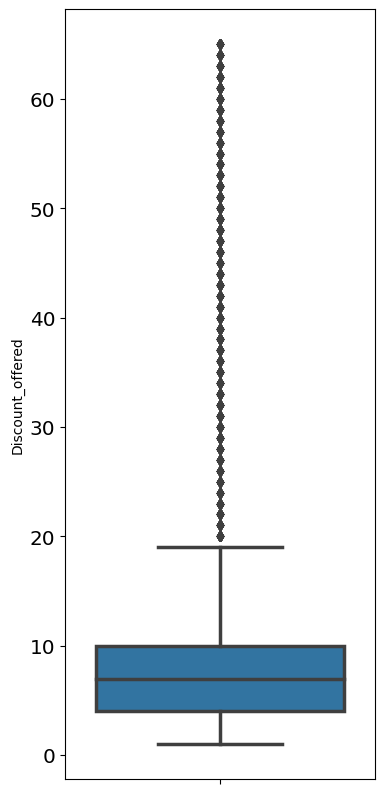

In [13]:
# Penghapusan outliers Discount_offered
plt.figure(figsize=(4,10))
sns.boxplot(y=X_train['Discount_offered'])

Karena outlier dapat dibilang sangat banyak dan memiliki korelasi kuat dengan feature target, maka tidak akan dilakukan penghapusan karena akan menghilangkan banyak sekali informasi

Sebagai gantinya, akan dilakukan **Winsorize** yaitu mengganti extream value dengan nilai quantile 95,
hal ini dilakukan agar machine tetap bisa mempelajari adanya korelasi tanpa merusak model

> Refrensi : [Handle many outliers](https://blog.devgenius.io/too-many-outliers-winsorization-6f120e7e8257)

In [14]:
print('Mean before: ', X_train['Discount_offered'].mean())
X_train['Discount_offered'] = winsorize(X_train['Discount_offered'], (0, 0.21))
print('Mean after: ', X_train['Discount_offered'].mean())

Mean before:  13.399975040559092
Mean after:  8.193435667041058


<AxesSubplot:ylabel='Discount_offered'>

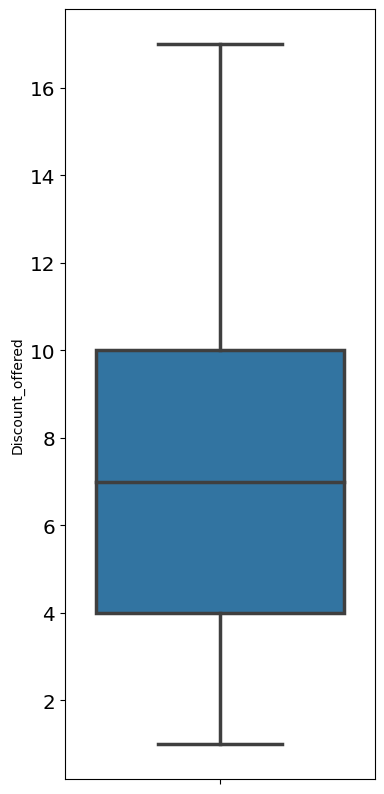

In [15]:
plt.figure(figsize=(4,10))
sns.boxplot(y=X_train['Discount_offered'])

<AxesSubplot:xlabel='Discount_offered', ylabel='Count'>

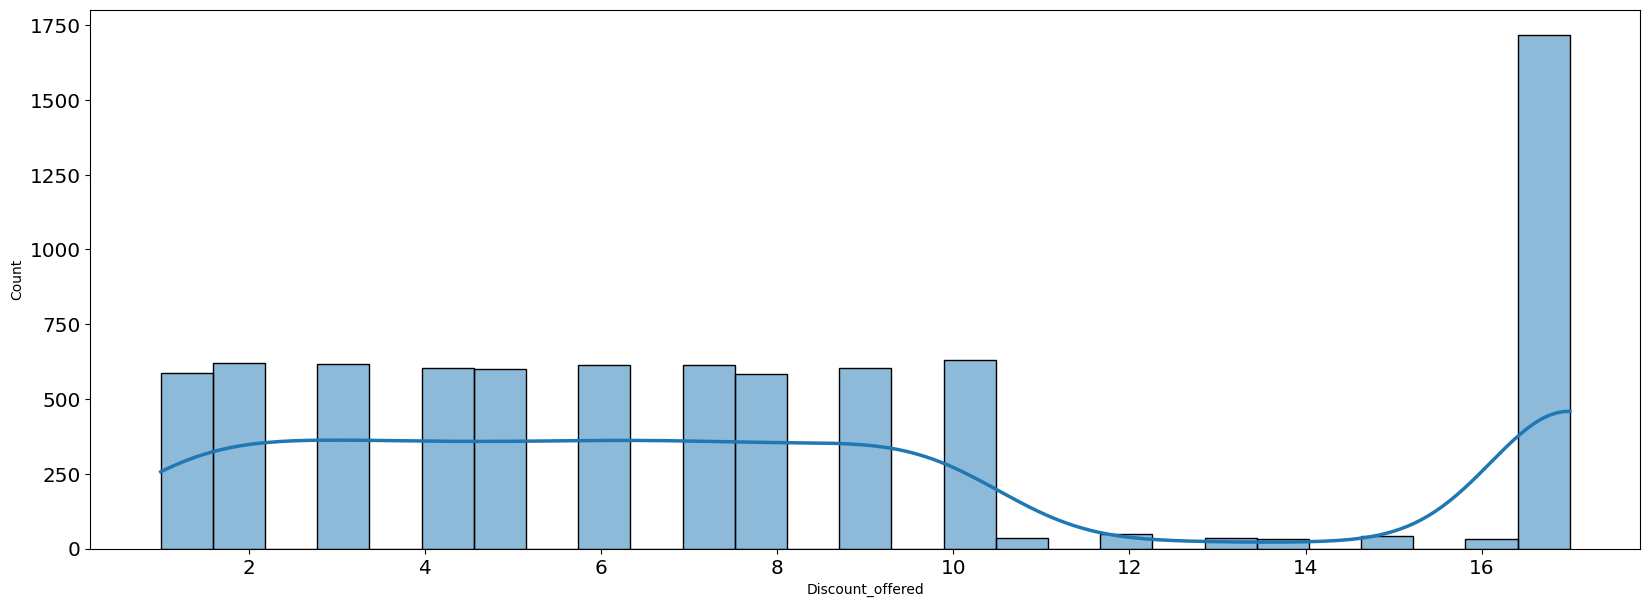

In [16]:
sns.histplot(kde=True, data=X_train['Discount_offered'])

## Feature Scaling

In [17]:
mm = MinMaxScaler()
for col in ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']:
    scaler = mm.fit(X_train[[col]])
    X_train[col] = scaler.transform(X_train[[col]])
    X_test[col] = scaler.transform(X_test[[col]])
    X[col] = scaler.transform(X[[col]])

In [18]:
nums = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
X_train[nums].head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
5933,0.2,0.00,0.406542,0.000000,0.5625,0.525493
5177,0.2,0.25,0.607477,0.666667,0.4375,0.617093
8406,0.2,0.00,0.663551,0.000000,0.2500,0.489993
8731,0.6,0.25,0.663551,0.000000,0.2500,0.686925
9754,0.4,1.00,0.219626,0.333333,0.0625,0.626004


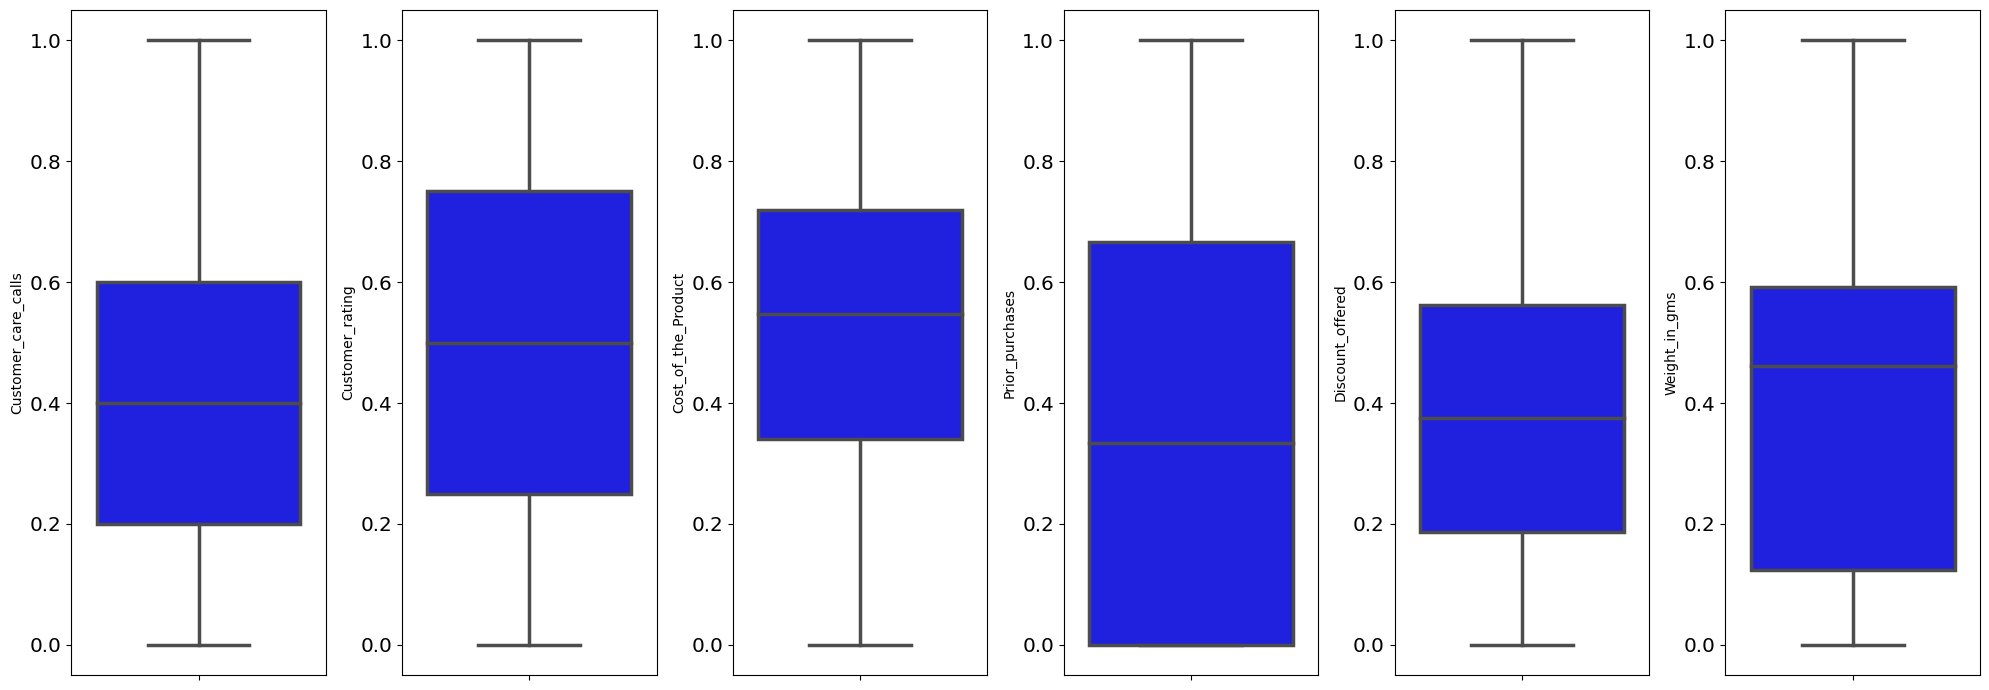

In [19]:
for i in range(len(nums)):
    plt.subplot(1, len(nums), i+1)
    sns.boxplot(y=X_train[nums[i]], color='blue', orient='v')
    plt.tight_layout()

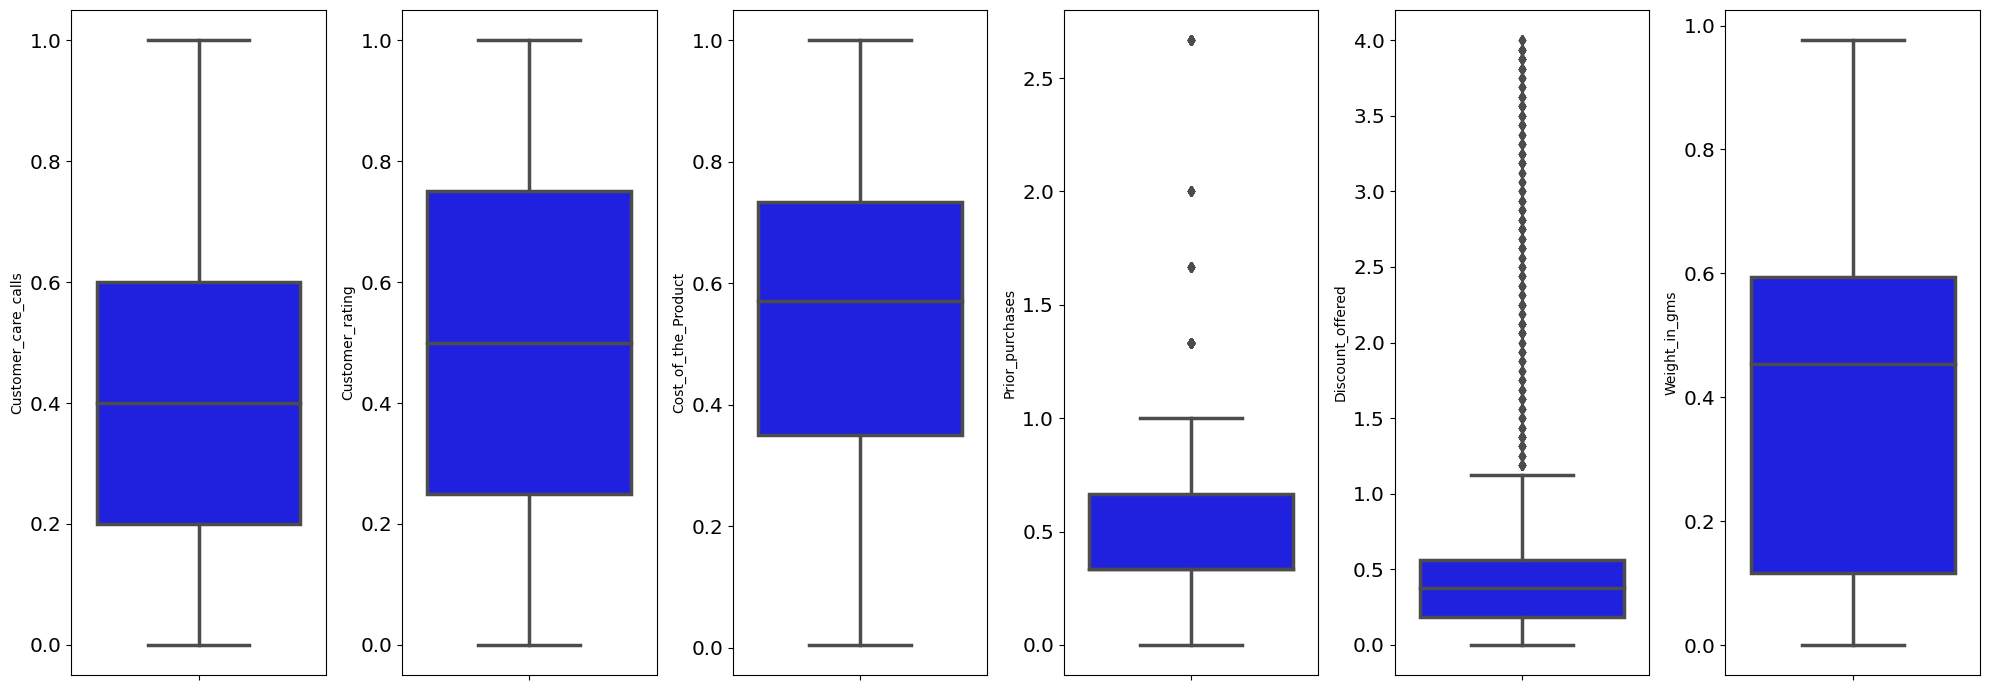

In [20]:
for i in range(len(nums)):
    plt.subplot(1, len(nums), i+1)
    sns.boxplot(y=X_test[nums[i]], color='blue', orient='v')
    plt.tight_layout()

In [21]:
X_train[nums].describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
count,8013.000000,8013.000000,8013.000000,8013.000000,8013.000000,8013.000000
mean,0.409809,0.495133,0.531382,0.403511,0.449590,0.387084
std,0.229020,0.355215,0.225584,0.324005,0.337457,0.237992
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.250000,0.341121,0.000000,0.187500,0.124324
50%,0.400000,0.500000,0.546729,0.333333,0.375000,0.461505
75%,0.600000,0.750000,0.719626,0.666667,0.562500,0.591673
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
X_test[nums].describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,0.411727,0.503750,0.542961,0.541970,0.788977,0.377658
std,0.232879,0.347574,0.222882,0.538973,1.034041,0.241902
min,0.000000,0.000000,0.004673,0.000000,0.000000,0.000292
25%,0.200000,0.250000,0.350467,0.333333,0.187500,0.116983
50%,0.400000,0.500000,0.570093,0.333333,0.375000,0.453543
75%,0.600000,0.750000,0.733645,0.666667,0.562500,0.593572
max,1.000000,1.000000,1.000000,2.666667,4.000000,0.976333


## Feature Encoding

In [23]:
#Label Encoding
mapping_prod_imp = {
    'low': 0,
    'medium': 1,
    'high': 2
}
X_train['Product_importance'] = X_train['Product_importance'].map(mapping_prod_imp)
X_test['Product_importance'] = X_test['Product_importance'].map(mapping_prod_imp)
X['Product_importance'] = X['Product_importance'].map(mapping_prod_imp)

In [24]:
# One Hot Encoding
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X = pd.get_dummies(X)

## Cek Class Imbalance

In [25]:
percentage = y_train.value_counts() / len(y_train) * 100
percentage

1    59.740422
0    40.259578
Name: Reached.on.Time_Y.N, dtype: float64

Berdasar hasil pengecekan kelas target diatas, perbandingan nilai yang ada berada dikisaran 40% - 60% sehingga dapat dianggap normal / **Tidak** imbalance

### Cek Bentuk Data

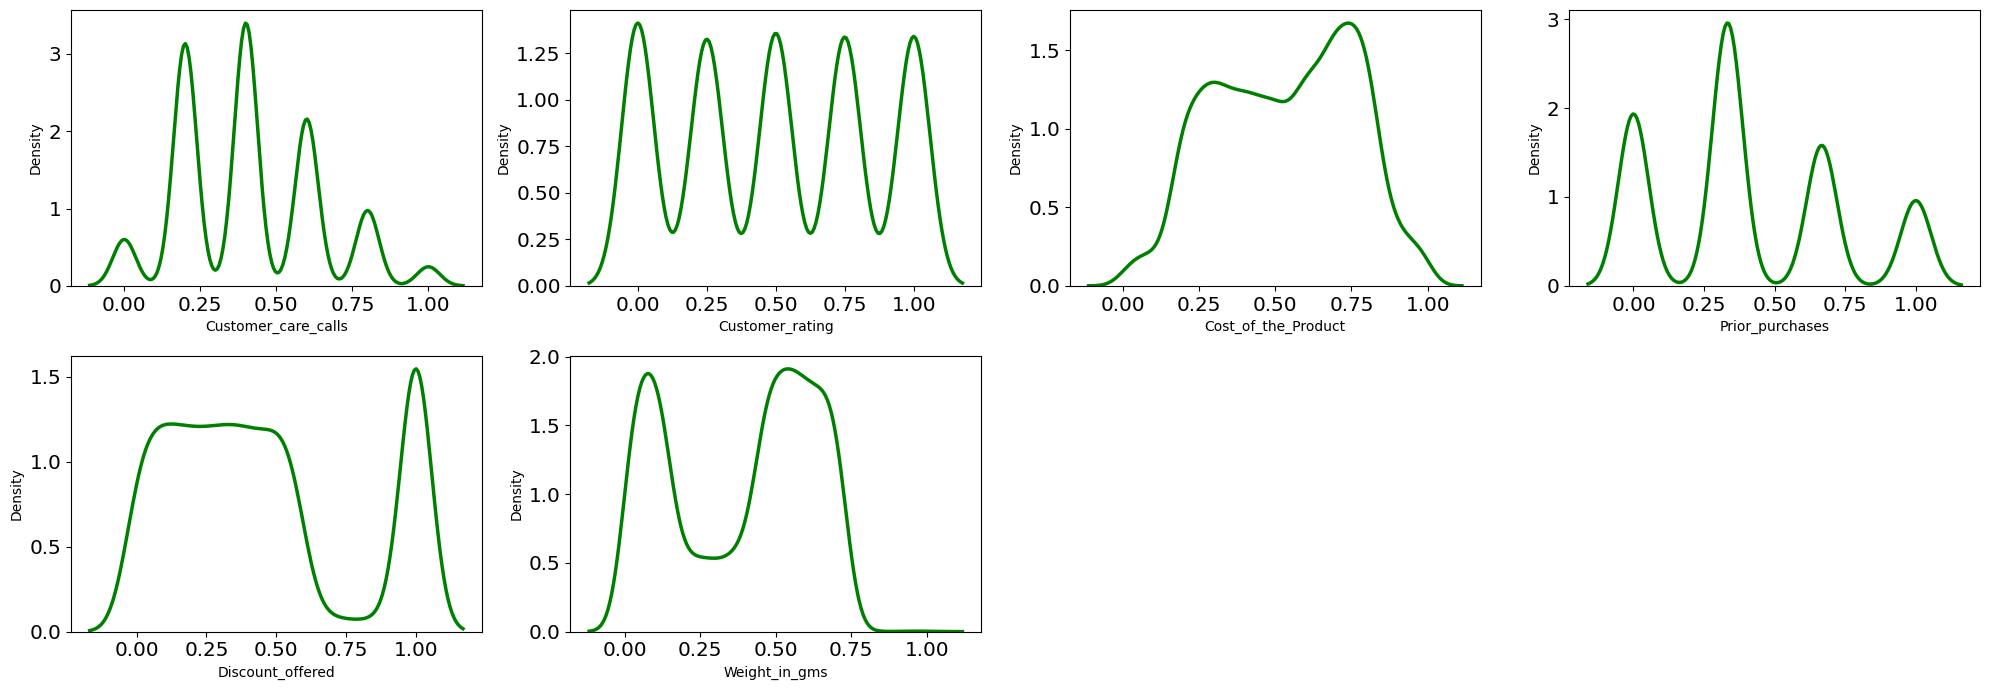

In [26]:
numerical = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
for i in range(0, len(numerical)):
  plt.subplot(2, 4, i+1) # len(features), i+1
  sns.kdeplot(x=X_train[numerical[i]], color = 'green')
  plt.xlabel(numerical[i])
  plt.tight_layout()

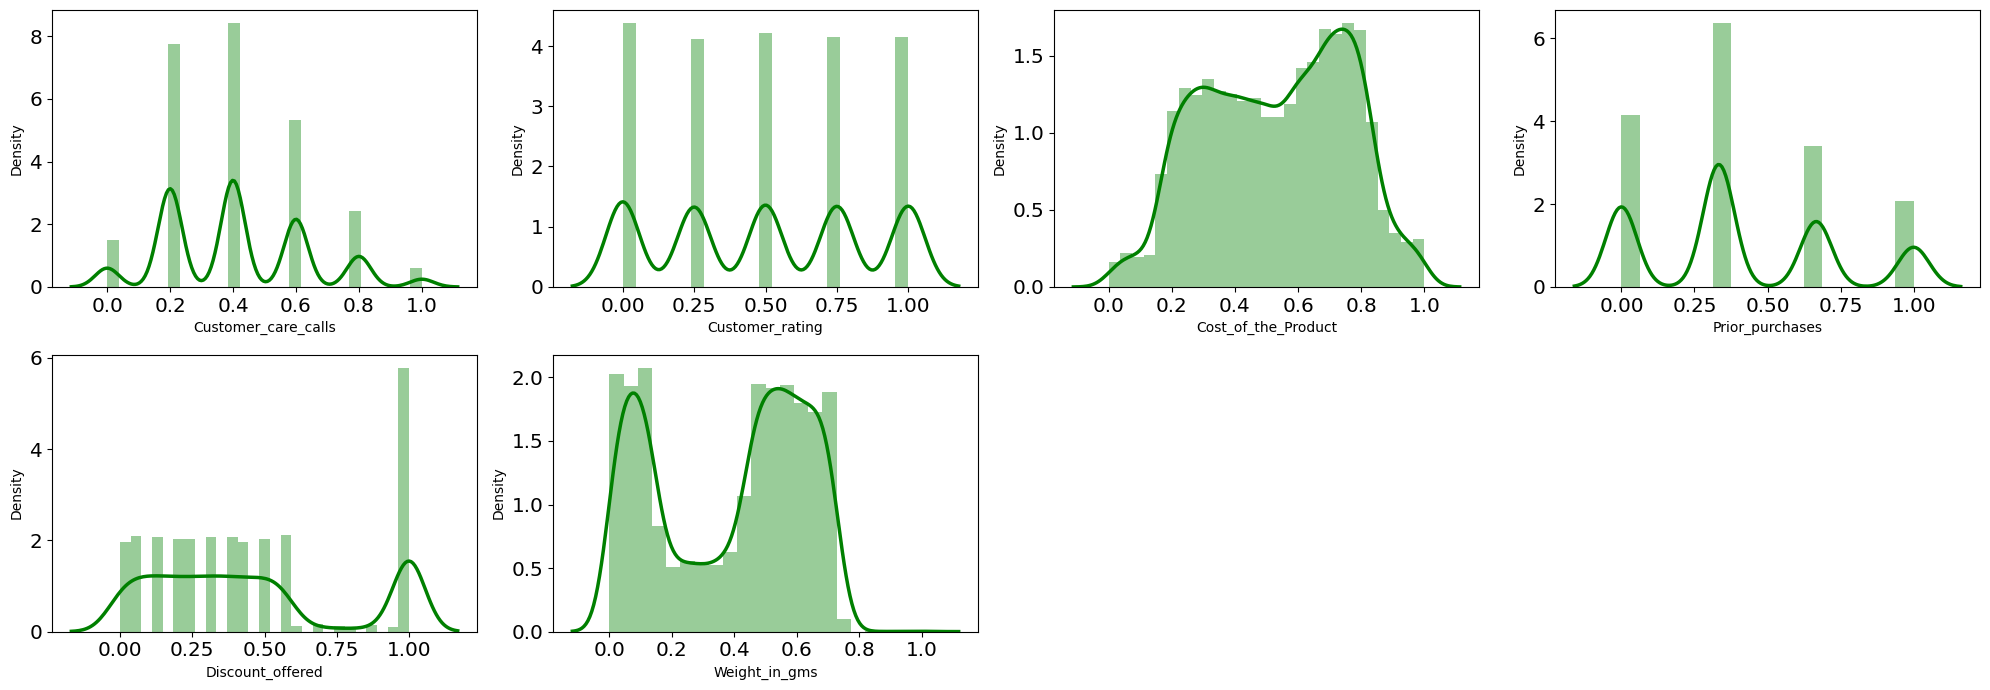

In [27]:
for i in range(0, len(numerical)):
  plt.subplot(2, 4, i+1) # len(features), i+1
  sns.distplot(x=X_train[numerical[i]], color = 'green')
  plt.xlabel(numerical[i])
  plt.tight_layout()

## Feature Engineering

### Feature Selection

Setelah dilihat dari persebaran datanya saat EDA melalui visualisasi, feature **Gender** dapat dihapus karena nilainya yang hampir balance pada semua aspek sehingga dapat dianggap tidak mempengaruhi apa pun

In [28]:
X_train = X_train.drop(['Gender_F', 'Gender_M'], axis=1)
X_test = X_test.drop(['Gender_F', 'Gender_M'], axis=1)
X = X.drop(['Gender_F', 'Gender_M'], axis=1)

In [29]:
X_test

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_E,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship
7392,0.6,0.50,0.364486,0.333333,1,0.3125,0.593572,0,0,0,1,0,0,1,0
5258,1.0,0.50,1.000000,0.666667,1,0.4375,0.125493,1,0,0,0,0,0,0,1
8220,0.4,0.75,0.803738,0.333333,1,0.5625,0.515705,0,0,0,1,0,1,0,0
7786,0.6,0.75,0.588785,0.333333,0,0.0000,0.559971,0,0,1,0,0,0,1,0
2592,0.4,0.00,0.439252,0.333333,0,1.9375,0.259021,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6865,0.8,0.50,0.794393,0.666667,0,0.5000,0.127831,0,0,0,0,1,1,0,0
5323,0.4,0.75,0.663551,0.333333,1,0.2500,0.543901,0,0,0,0,1,0,1,0
4298,0.2,1.00,0.205607,0.333333,0,0.5000,0.545215,1,0,0,0,0,0,0,1
8821,0.8,0.00,0.766355,0.666667,0,0.3125,0.111760,0,0,0,0,1,0,0,1


### Feature Extraction

Karena semua feature dianggap sudah sesuai dan tidak ada feature kategorikal yang memiliki nilai unik yang sangat banyak, maka Feature Extraction dirasa **tidak diperlukan**

# Modelling

In [30]:
def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)
    
    print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
    print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
    print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
    print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
    
    print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))
    print("roc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
    
    score = cross_validate(model, X, Y, cv=5, scoring='recall', return_train_score=True)
    print('recall (crossval train): '+ str(score['train_score'].mean()))
    print('recall (crossval test): '+ str(score['test_score'].mean()))
    
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

In [31]:
def class_report_train(model):
    y_pred_train = model.predict(X_train)
    print(classification_report(y_train, y_pred_train))


def class_report_test(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

## Logistic Regression

In [32]:
logreg = LogisticRegression(random_state = 42) # inisiasi object dengan nama logreg
logreg.fit(X_train, y_train) # fit model regression dari data train
eval_classification(logreg)

Accuracy (Test Set): 0.64
Accuracy (Train Set): 0.64
Recall (Test Set): 0.69
Recall (Train Set): 0.71
roc_auc (test-proba): 0.72
roc_auc (train-proba): 0.73
recall (crossval train): 0.7041380381061203
recall (crossval test): 0.623704442442368


In [33]:
class_report_train(logreg)

              precision    recall  f1-score   support

           0       0.56      0.53      0.54      3226
           1       0.69      0.71      0.70      4787

    accuracy                           0.64      8013
   macro avg       0.62      0.62      0.62      8013
weighted avg       0.64      0.64      0.64      8013



In [34]:
class_report_test(logreg)

              precision    recall  f1-score   support

           0       0.55      0.56      0.55       887
           1       0.70      0.69      0.69      1313

    accuracy                           0.64      2200
   macro avg       0.62      0.63      0.62      2200
weighted avg       0.64      0.64      0.64      2200



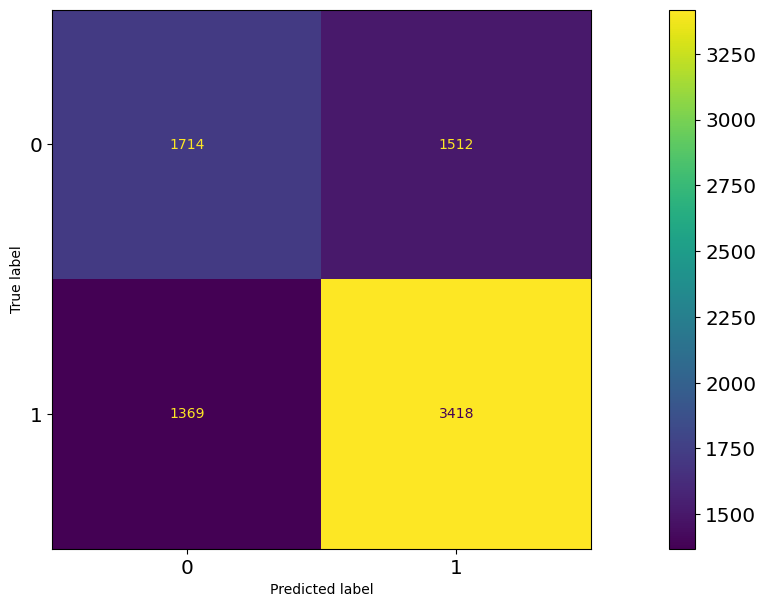

In [35]:
#Confusion Matrix Train vs Prediction
cm1_logreg = confusion_matrix(y_train, logreg.predict(X_train), labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1_logreg,
                              display_labels=logreg.classes_)
disp.plot()
plt.show()

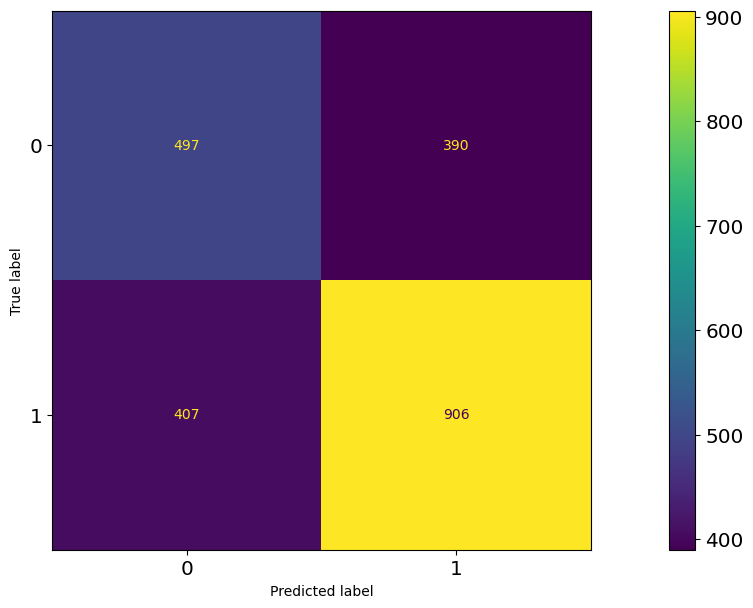

In [36]:
#Confusion Matrix Test vs Prediction
cm2_logreg = confusion_matrix(y_test, logreg.predict(X_test), labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2_logreg,
                              display_labels=logreg.classes_)
disp.plot()
plt.show()

In [37]:
#Percobaan 1
penalty = ['l1', 'l2']
C = [float(x) for x in np.linspace(0.0001, 0.05, 100)]
hyperparameters = dict(penalty=penalty, C=C)

logreg = LogisticRegression(random_state = 42)
rs1_logreg = RandomizedSearchCV(logreg, hyperparameters, scoring='recall', random_state=42, cv=5, n_iter=50)
rs1_logreg.fit(X_train, y_train)
eval_classification(rs1_logreg)

Accuracy (Test Set): 0.60
Accuracy (Train Set): 0.60
Recall (Test Set): 0.95
Recall (Train Set): 0.98
roc_auc (test-proba): 0.71
roc_auc (train-proba): 0.72
recall (crossval train): 0.8167453346754814
recall (crossval test): 0.6992869150892574


In [38]:
show_best_hyperparameter(rs1_logreg)

{'C': 0.002116161616161616, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


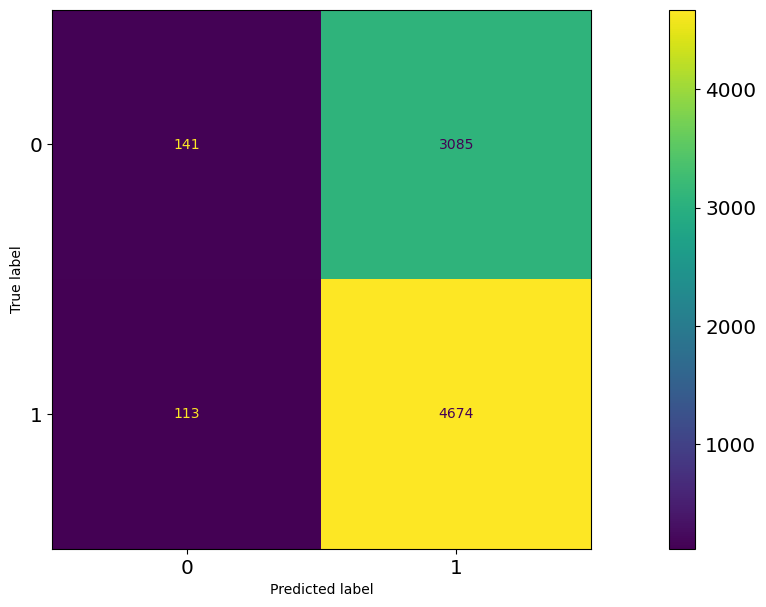

In [39]:
#confusion matrix train vs predict untuk percobaan 1
cm3_logreg = confusion_matrix(y_train, rs1_logreg.predict(X_train), labels=rs1_logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm3_logreg,
                              display_labels=rs1_logreg.classes_)
disp.plot()
plt.show()

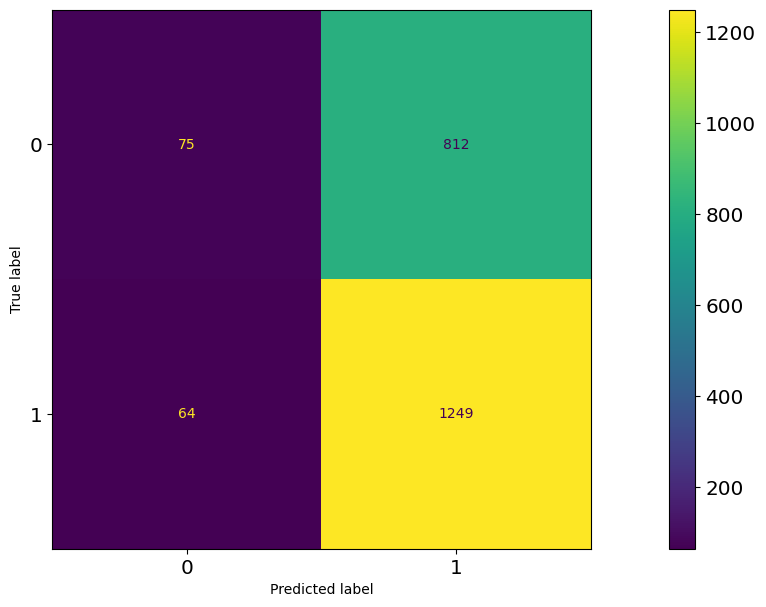

In [40]:
#confusion matrix test vs predict untuk percobaan 1
cm4_logreg = confusion_matrix(y_test, rs1_logreg.predict(X_test), labels=rs1_logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm4_logreg,
                              display_labels=rs1_logreg.classes_)
disp.plot()
plt.show()

In [41]:
#Percobaan 2: dengan Best HT
penalty = ['l2']
C = [float(x) for x in np.linspace(0.0026202020202020205, 0.01, 100)]
hyperparameters = dict(penalty=penalty, C=C)

logreg = LogisticRegression(random_state = 42)
rs2_logreg = RandomizedSearchCV(logreg, hyperparameters, scoring='recall', random_state=42, cv=5, n_iter=50)
rs2_logreg.fit(X_train, y_train)
eval_classification(rs2_logreg)

Accuracy (Test Set): 0.60
Accuracy (Train Set): 0.61
Recall (Test Set): 0.91
Recall (Train Set): 0.95
roc_auc (test-proba): 0.71
roc_auc (train-proba): 0.72
recall (crossval train): 0.7967842859863428
recall (crossval test): 0.684352070291457


In [42]:
class_report_train(rs2_logreg)

              precision    recall  f1-score   support

           0       0.56      0.10      0.17      3226
           1       0.61      0.95      0.74      4787

    accuracy                           0.61      8013
   macro avg       0.58      0.52      0.46      8013
weighted avg       0.59      0.61      0.51      8013



In [43]:
class_report_test(rs2_logreg)

              precision    recall  f1-score   support

           0       0.52      0.13      0.21       887
           1       0.61      0.91      0.73      1313

    accuracy                           0.60      2200
   macro avg       0.56      0.52      0.47      2200
weighted avg       0.57      0.60      0.52      2200



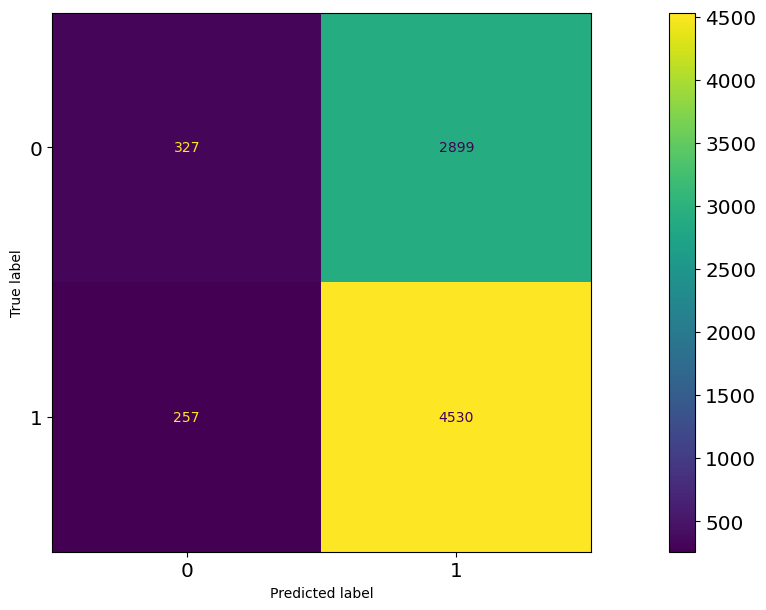

In [44]:
#confusion matrix train vs predict untuk percobaan 2
cm5_logreg = confusion_matrix(y_train, rs2_logreg.predict(X_train), labels=rs2_logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm5_logreg,
                              display_labels=rs2_logreg.classes_)
disp.plot()
plt.show()

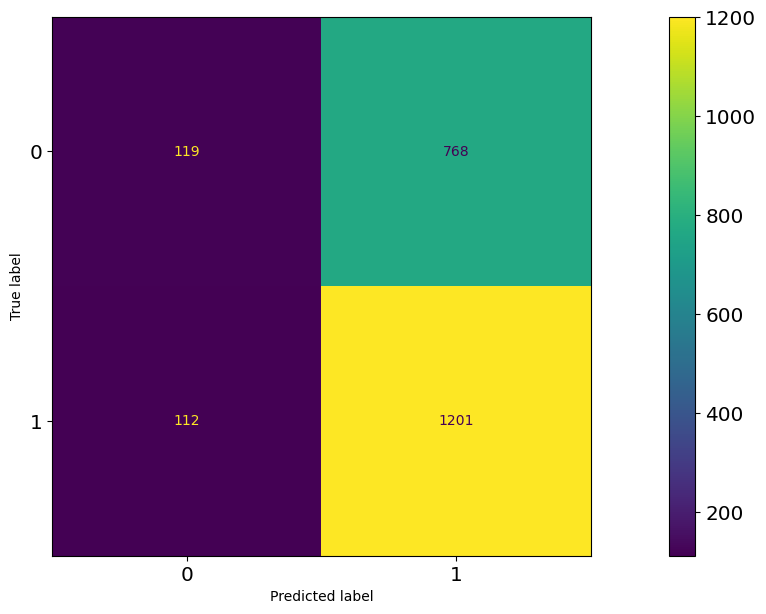

In [45]:
#confusion matrix test vs predict untuk percobaan 2
cm6_logreg = confusion_matrix(y_test, rs2_logreg.predict(X_test), labels=rs2_logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm6_logreg,
                              display_labels=rs2_logreg.classes_)
disp.plot()
plt.show()

param value: 0.0026202020202020205; train: 0.9463129308543973; test: 0.9146991622239147
param value: 0.002694745434139374; train: 0.940672655107583; test: 0.9086062452399086
param value: 0.0027692888480767273; train: 0.934614581157301; test: 0.9017517136329017
param value: 0.0028438322620140803; train: 0.9310632964278254; test: 0.897943640517898
param value: 0.0029183756759514337; train: 0.9268853143931481; test: 0.8956587966488957
param value: 0.002992919089888787; train: 0.9233340296636724; test: 0.8933739527798934
param value: 0.0030674625038261405; train: 0.9187382494255275; test: 0.884996191926885
param value: 0.003142005917763494; train: 0.9151869646960518; test: 0.8811881188118812
param value: 0.0032165493317008473; train: 0.9101733862544391; test: 0.8781416603198782
param value: 0.0032910927456382003; train: 0.9059954042197619; test: 0.8766184310738766
param value: 0.0033656361595755537; train: 0.901190724879883; test: 0.8705255140898706
param value: 0.003440179573512907; train

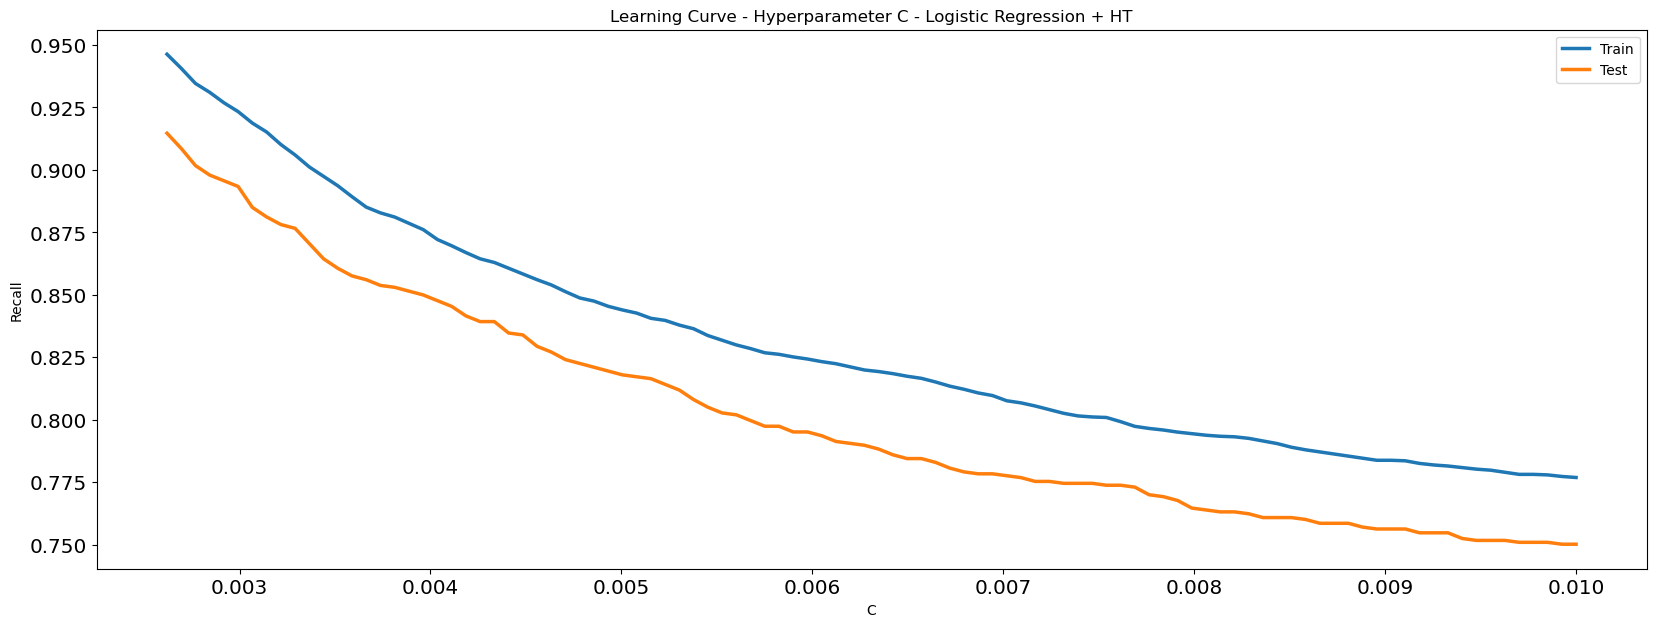

In [46]:
#Hyperparameter Tuning
param_values = [float(x) for x in np.linspace(0.0026202020202020205, 0.01, 100)]
train_scores = []
test_scores = []

for c in param_values:
    model = LogisticRegression(penalty='l2', C=c, random_state = 42)
    model.fit(X_train, y_train)

    # eval on train
    y_pred_train = model.predict(X_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_scores.append(train_recall)

    # eval on test
    y_pred = model.predict(X_test)
    test_recall = recall_score(y_test, y_pred)
    test_scores.append(test_recall)

    print('param value: ' + str(c) + '; train: ' + str(train_recall) + '; test: '+ str(test_recall))

plt.plot(param_values, train_scores, label='Train')
plt.plot(param_values, test_scores, label='Test')
plt.xlabel('C')
plt.ylabel('Recall')
plt.title('Learning Curve - Hyperparameter C - Logistic Regression + HT')
plt.legend()
plt.show()

nilai c yang menciptakan model besfit berada di interval **0.001 - 0.00262** namun performa model menurun hingga 0.08 pada c = 0.00262.

Feature: 0, Score: -0.10763
Feature: 1, Score: 0.02397
Feature: 2, Score: -0.07029
Feature: 3, Score: -0.15361
Feature: 4, Score: 0.05277
Feature: 5, Score: 0.73146
Feature: 6, Score: -0.38164
Feature: 7, Score: -0.02543
Feature: 8, Score: 0.01665
Feature: 9, Score: 0.00219
Feature: 10, Score: 0.02962
Feature: 11, Score: -0.02302
Feature: 12, Score: 0.01778
Feature: 13, Score: -0.00970
Feature: 14, Score: -0.00808


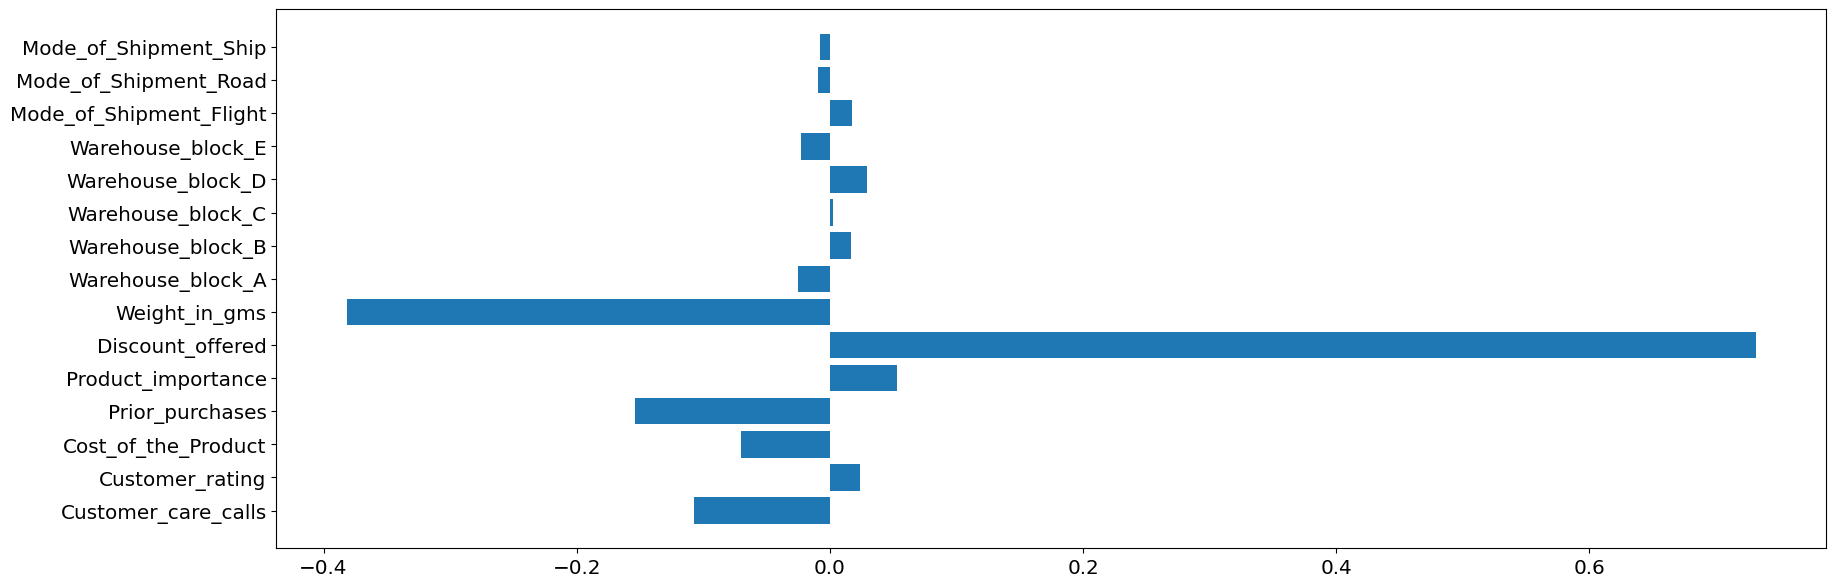

In [47]:
#percobaan 1
importance = rs1_logreg.best_estimator_.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.barh([x for x in X_train], importance)
plt.show()

Feature: 0, Score: -0.12510
Feature: 1, Score: 0.02813
Feature: 2, Score: -0.07973
Feature: 3, Score: -0.17701
Feature: 4, Score: 0.05697
Feature: 5, Score: 0.83832
Feature: 6, Score: -0.44528
Feature: 7, Score: -0.02887
Feature: 8, Score: 0.01830
Feature: 9, Score: 0.00251
Feature: 10, Score: 0.03383
Feature: 11, Score: -0.02577
Feature: 12, Score: 0.02002
Feature: 13, Score: -0.01080
Feature: 14, Score: -0.00923


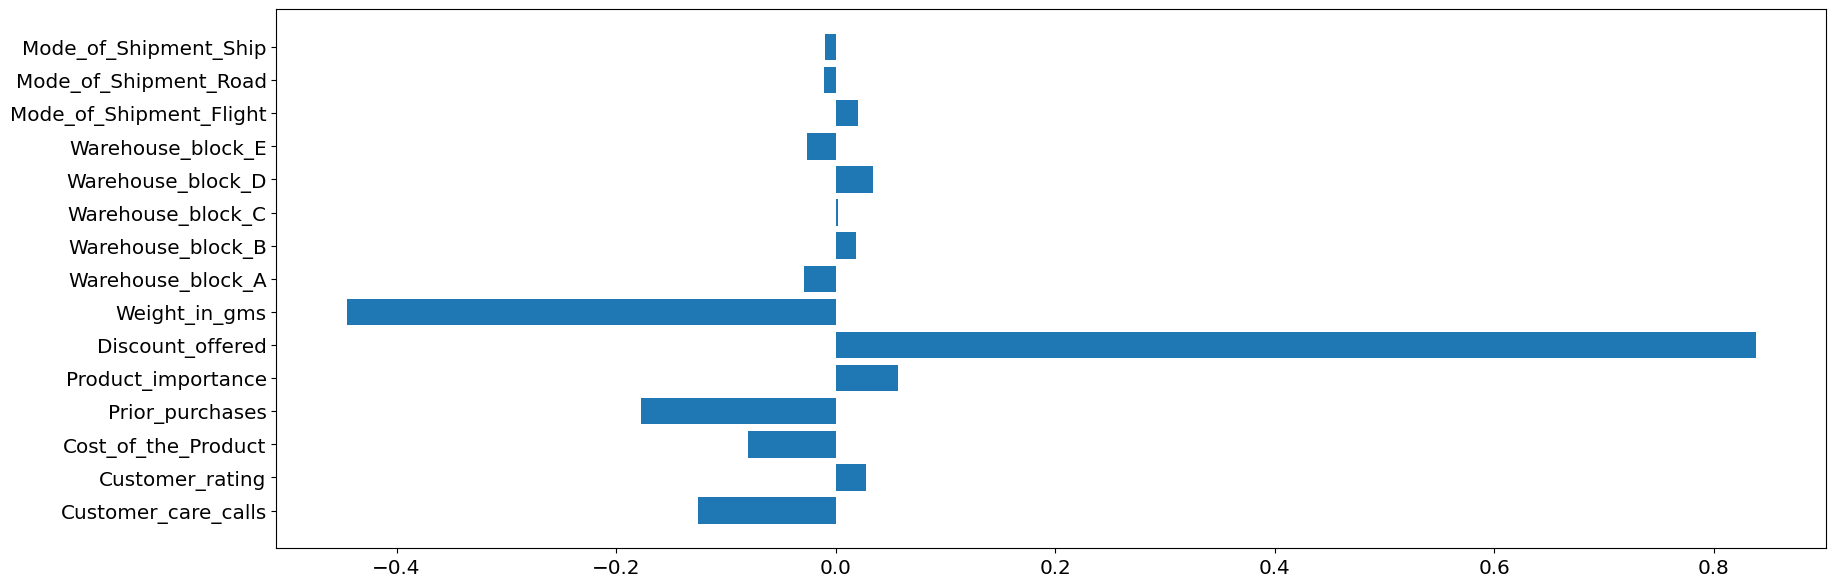

In [48]:
#percobaan 2
importance = rs2_logreg.best_estimator_.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.barh([x for x in X_train], importance)
plt.show()

## KNN

In [49]:
knn = KNeighborsClassifier() # inisiasi object dengan nama knn
knn.fit(X_train, y_train) # fit model KNN dari data train
eval_classification(knn)

Accuracy (Test Set): 0.65
Accuracy (Train Set): 0.78
Recall (Test Set): 0.68
Recall (Train Set): 0.79
roc_auc (test-proba): 0.71
roc_auc (train-proba): 0.86
recall (crossval train): 0.7795977473678483
recall (crossval test): 0.6141067049950774


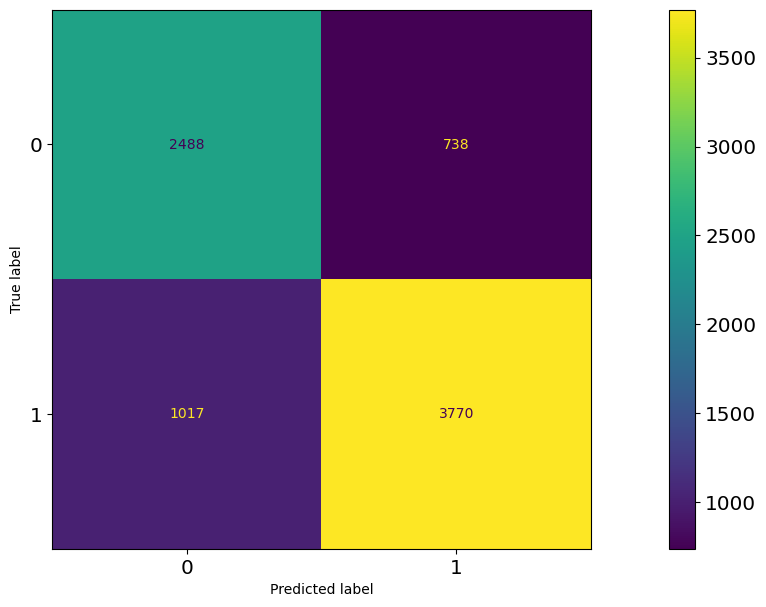

In [50]:
cm1 = confusion_matrix(y_train, knn.predict(X_train), labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1,
                              display_labels=knn.classes_)
disp.plot()
plt.show()

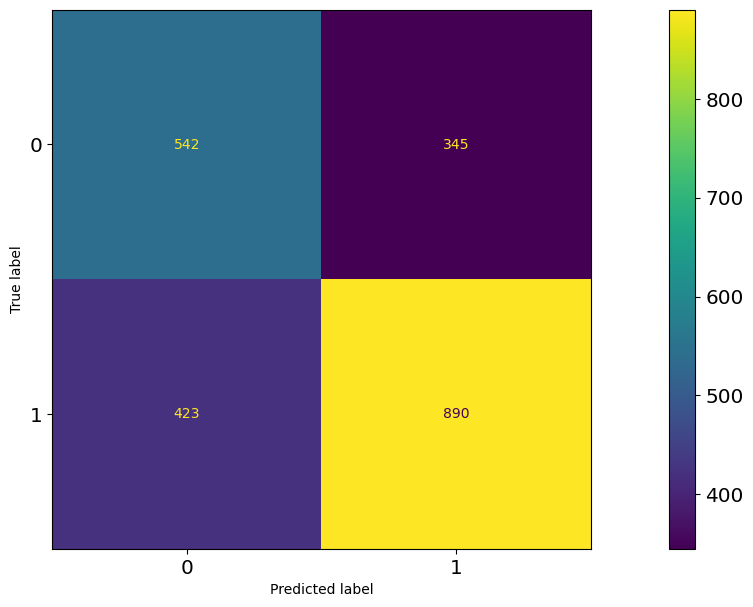

In [51]:
cm2 = confusion_matrix(y_test, knn.predict(X_test), labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2,
                              display_labels=knn.classes_)
disp.plot()
plt.show()

In [52]:
class_report_train(knn)

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      3226
           1       0.84      0.79      0.81      4787

    accuracy                           0.78      8013
   macro avg       0.77      0.78      0.78      8013
weighted avg       0.79      0.78      0.78      8013



In [53]:
class_report_test(knn)

              precision    recall  f1-score   support

           0       0.56      0.61      0.59       887
           1       0.72      0.68      0.70      1313

    accuracy                           0.65      2200
   macro avg       0.64      0.64      0.64      2200
weighted avg       0.66      0.65      0.65      2200



**mencari nilai k dengan akurasi terbaik**

In [54]:
accuracies = []
for k in range(1, 25):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred_test = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    accuracies.append(accuracy)
for k in range(1,25):
    print("k = ", k, " => Akurasi = ", np.round(accuracies[k-1], 3)) 

# Bebas memilih k, tapi jika k semakin besar & datanya besar maka akan semakin lambat proses runtime. 
# Jika perbedaan tipis, maka pilih k yang kecil saja
# Pilih k yang ganjil lebih baik agar tidak imbang.

k =  1  => Akurasi =  0.637
k =  2  => Akurasi =  0.647
k =  3  => Akurasi =  0.649
k =  4  => Akurasi =  0.653
k =  5  => Akurasi =  0.651
k =  6  => Akurasi =  0.653
k =  7  => Akurasi =  0.643
k =  8  => Akurasi =  0.648
k =  9  => Akurasi =  0.635
k =  10  => Akurasi =  0.645
k =  11  => Akurasi =  0.639
k =  12  => Akurasi =  0.648
k =  13  => Akurasi =  0.639
k =  14  => Akurasi =  0.645
k =  15  => Akurasi =  0.635
k =  16  => Akurasi =  0.647
k =  17  => Akurasi =  0.638
k =  18  => Akurasi =  0.655
k =  19  => Akurasi =  0.646
k =  20  => Akurasi =  0.65
k =  21  => Akurasi =  0.64
k =  22  => Akurasi =  0.66
k =  23  => Akurasi =  0.643
k =  24  => Akurasi =  0.655


**Nilai K terbaik untuk data train**

In [55]:
best_k = 1
best_accuracy = 0
best_recall = 0
for k in range(1, 25):
    knn = KNeighborsClassifier(n_neighbors=k)
    # cross valid untuk akurasi & recall
    accuracy_scores = cross_val_score(knn, X, Y, cv=5, scoring='accuracy')
    recall_scores = cross_val_score(knn, X, Y, cv=5, scoring='recall_macro')
    # mean akurasi & recall
    mean_accuracy = np.mean(accuracy_scores)
    mean_recall = np.mean(recall_scores)
    # K & score terbaik
    if mean_accuracy > best_accuracy:
        best_k = k
        best_accuracy = mean_accuracy
    if mean_recall > best_recall:
        best_recall = mean_recall

print("Best k for KNN model:", best_k)
print("Best accuracy:", best_accuracy)
print("Best recall:", best_recall)

Best k for KNN model: 2
Best accuracy: 0.6197662987308281
Best recall: 0.6484605971772164


In [56]:
knn10 = KNeighborsClassifier(n_neighbors = 10)

**K = 10 DATA TRAIN**

In [57]:
knn10.fit(X_train, y_train)
y_train10 = knn10.predict(X_train)

In [58]:
class_report_train(knn10)

              precision    recall  f1-score   support

           0       0.62      0.83      0.71      3226
           1       0.85      0.65      0.74      4787

    accuracy                           0.73      8013
   macro avg       0.74      0.74      0.72      8013
weighted avg       0.76      0.73      0.73      8013



In [59]:
class_report_test(knn10)

              precision    recall  f1-score   support

           0       0.55      0.72      0.62       887
           1       0.76      0.60      0.67      1313

    accuracy                           0.65      2200
   macro avg       0.65      0.66      0.64      2200
weighted avg       0.67      0.65      0.65      2200



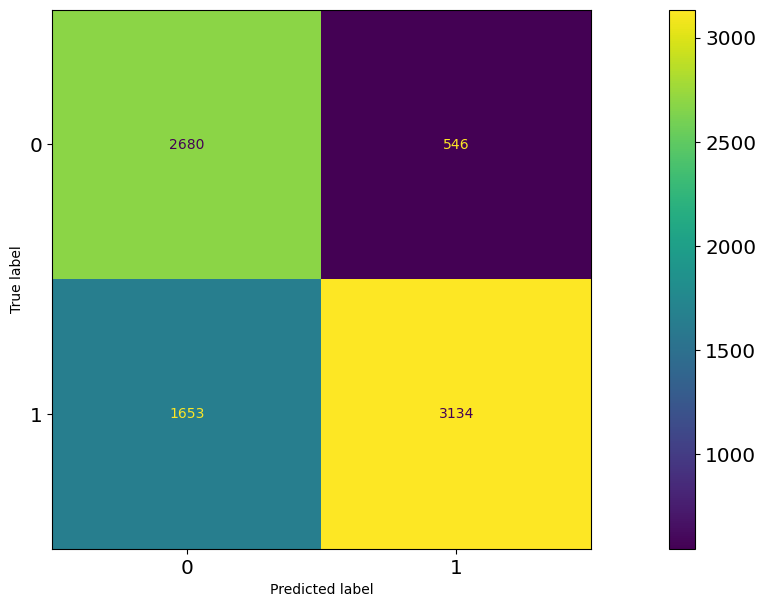

In [60]:
cm = confusion_matrix(y_train, knn10.predict(X_train), labels=knn10.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn10.classes_)
disp.plot()
plt.show()

**K = 10 DATA TEST**

In [61]:
y_pred = knn10.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.72      0.62       887
           1       0.76      0.60      0.67      1313

    accuracy                           0.65      2200
   macro avg       0.65      0.66      0.64      2200
weighted avg       0.67      0.65      0.65      2200



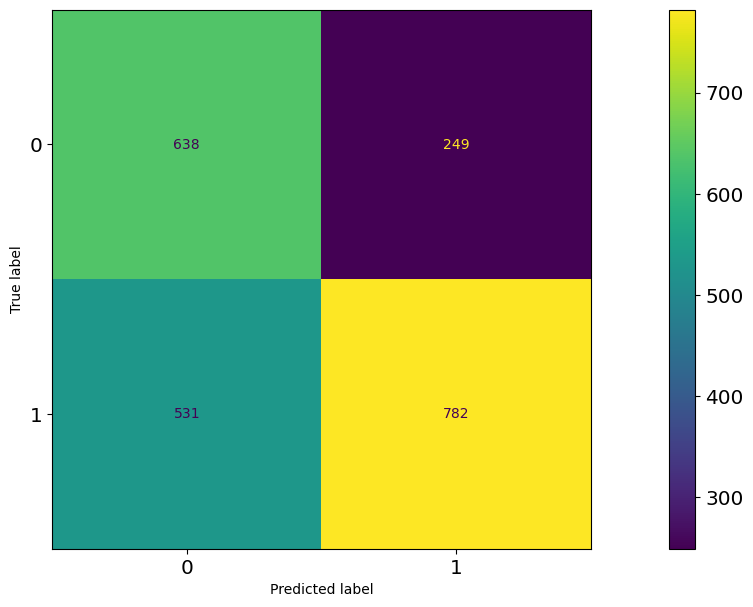

In [62]:
cm = confusion_matrix(y_test, knn10.predict(X_test), labels=knn10.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn10.classes_)
disp.plot()
plt.show()

**FIX OVERFIT**

In [63]:
knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(X_train, y_train)

eval_classification(knn_model)

Accuracy (Test Set): 0.65
Accuracy (Train Set): 0.73
Recall (Test Set): 0.60
Recall (Train Set): 0.65
roc_auc (test-proba): 0.71
roc_auc (train-proba): 0.82
recall (crossval train): 0.6563687279520455
recall (crossval test): 0.5257138976092731


In [64]:
hyperparameters = {'n_neighbors': range(1, 30),
                   'weights': ['uniform', 'distance'],
                   'p': [1, 2]} # jarak Euclidean (p=2) dan jarak Manhattan (p=1)

knn_hyper = KNeighborsClassifier()

# Masukin RandomizedSearchCV
rs = RandomizedSearchCV(knn_hyper, hyperparameters, scoring='recall', n_iter=50, cv=5, random_state=42)

# Fit RandomizedSearchCV
rs.fit(X_train, y_train)

# Print best hyperparameters and evaluation metrics
print('Best hyperparameters:', rs.best_params_)

Best hyperparameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 3}


In [65]:
knnmodel_hype = KNeighborsClassifier(n_neighbors=rs.best_params_['n_neighbors'], 
                                      weights=rs.best_params_['weights'], 
                                      p=rs.best_params_['p'])
# Training model dengan data training
knnmodel_hype.fit(X_train, y_train)

# Evaluasi performa model pada data test
y_pred = knnmodel_hype.predict(X_test)
eval_classification(knnmodel_hype)

Accuracy (Test Set): 0.65
Accuracy (Train Set): 1.00
Recall (Test Set): 0.69
Recall (Train Set): 1.00
roc_auc (test-proba): 0.70
roc_auc (train-proba): 1.00
recall (crossval train): 1.0
recall (crossval test): 0.6349882971411588


In [66]:
class_report_train(knnmodel_hype)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3226
           1       1.00      1.00      1.00      4787

    accuracy                           1.00      8013
   macro avg       1.00      1.00      1.00      8013
weighted avg       1.00      1.00      1.00      8013



In [67]:
class_report_test(knnmodel_hype)

              precision    recall  f1-score   support

           0       0.56      0.59      0.57       887
           1       0.71      0.69      0.70      1313

    accuracy                           0.65      2200
   macro avg       0.63      0.64      0.63      2200
weighted avg       0.65      0.65      0.65      2200



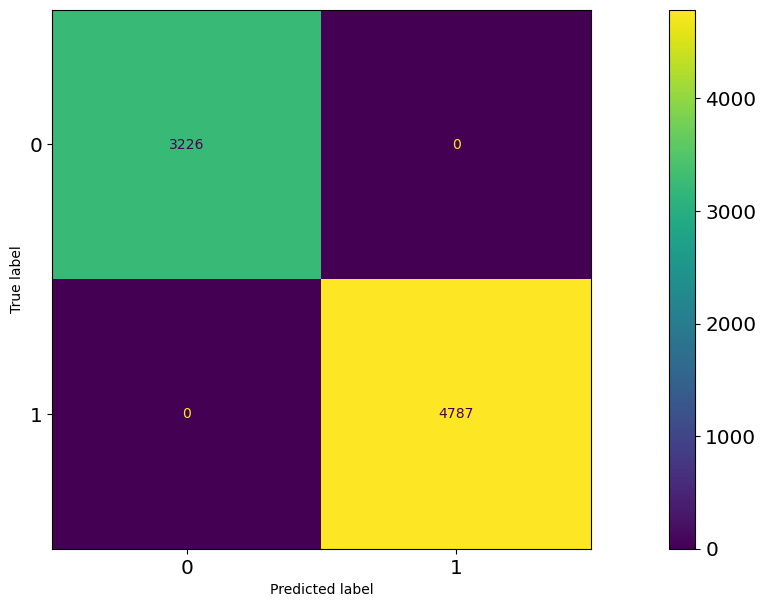

In [68]:
cm = confusion_matrix(y_train, knnmodel_hype.predict(X_train), labels=knnmodel_hype.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knnmodel_hype.classes_)
disp.plot()
plt.show()

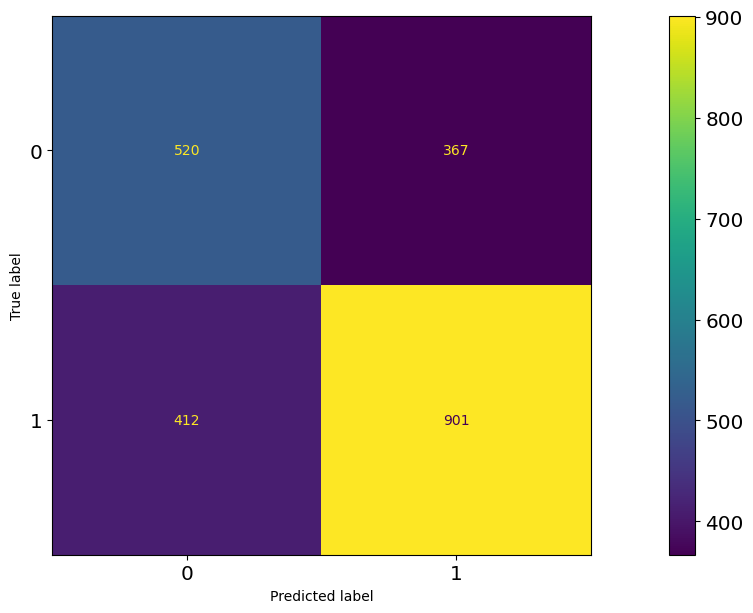

In [69]:
cm = confusion_matrix(y_test, knnmodel_hype.predict(X_test), labels=knnmodel_hype.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knnmodel_hype.classes_)
disp.plot()
plt.show()

**dengan setting HT distance measure p = 3**

In [70]:
n_neighbors = [int(x) for x in np.linspace(1, 100, 50)]
weights = ['uniform', 'distance']
p = [1,2,3]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
hyperparameters = dict(n_neighbors=n_neighbors, p=p, weights = weights, algorithm = algorithm)

knn.fit(X_train, y_train)
rs1_knn = RandomizedSearchCV(knn, hyperparameters, scoring='recall', random_state=42, cv=5)
rs1_knn.fit(X_train, y_train)
eval_classification(rs1_knn)

Accuracy (Test Set): 0.63
Accuracy (Train Set): 0.66
Recall (Test Set): 0.70
Recall (Train Set): 0.73
roc_auc (test-proba): 0.71
roc_auc (train-proba): 0.74
recall (crossval train): 0.7250888084809242
recall (crossval test): 0.5901730815670685


In [71]:
show_best_hyperparameter(rs1_knn)

{'algorithm': 'kd_tree', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 87, 'p': 2, 'weights': 'uniform'}


In [72]:
n_neighbors = [int(x) for x in np.linspace(81, 87, 50)]
weights = ['uniform']
p = [2]
algorithm = ['kd_tree']
hyperparameters = dict(n_neighbors=n_neighbors, p=p, weights = weights, algorithm = algorithm)

knn.fit(X_train, y_train)
rs2_knn = RandomizedSearchCV(knn, hyperparameters, scoring='recall', random_state=42, cv=5)
rs2_knn.fit(X_train, y_train)
eval_classification(rs2_knn)

Accuracy (Test Set): 0.63
Accuracy (Train Set): 0.66
Recall (Test Set): 0.70
Recall (Train Set): 0.73
roc_auc (test-proba): 0.71
roc_auc (train-proba): 0.74
recall (crossval train): 0.659764289795141
recall (crossval test): 0.5263157589211078


In [73]:
class_report_train(rs2_knn)

              precision    recall  f1-score   support

           0       0.58      0.55      0.57      3226
           1       0.71      0.73      0.72      4787

    accuracy                           0.66      8013
   macro avg       0.64      0.64      0.64      8013
weighted avg       0.66      0.66      0.66      8013



In [74]:
class_report_test(rs2_knn)

              precision    recall  f1-score   support

           0       0.54      0.51      0.53       887
           1       0.68      0.70      0.69      1313

    accuracy                           0.63      2200
   macro avg       0.61      0.61      0.61      2200
weighted avg       0.62      0.63      0.62      2200



## Decision Tree

In [75]:
dt = DecisionTreeClassifier(random_state=42) # inisiasi object dengan nama dt
dt.fit(X_train, y_train) # fit model decision tree dari data train
eval_classification(dt)

Accuracy (Test Set): 0.65
Accuracy (Train Set): 1.00
Recall (Test Set): 0.72
Recall (Train Set): 1.00
roc_auc (test-proba): 0.63
roc_auc (train-proba): 1.00
recall (crossval train): 1.0
recall (crossval test): 0.6752139719131388


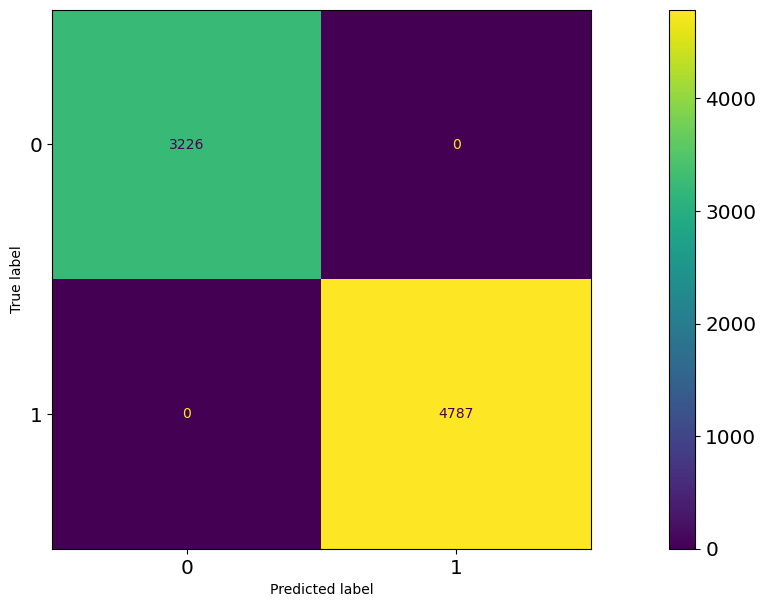

In [76]:
#confusion matrix train tanpa HT
cm1_dt = confusion_matrix(y_train, dt.predict(X_train), labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1_dt, display_labels=dt.classes_)

disp.plot()

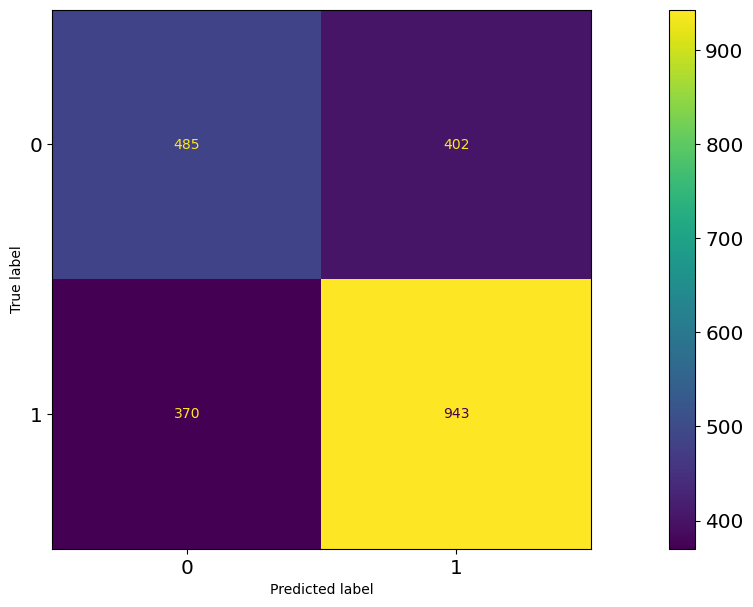

In [77]:
#confusion matrix test tanpa HT
cm2_dt = confusion_matrix(y_test, dt.predict(X_test), labels=dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2_dt, display_labels=dt.classes_)

disp.plot()

In [78]:
# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
criterion = ['gini','entropy']
splitter = ['best','random']

hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion=criterion,
                       splitter=splitter
                      )

In [79]:
# Inisialisasi Model
dt = DecisionTreeClassifier(random_state=42)
rs1_dt = RandomizedSearchCV(dt, hyperparameters, random_state = 42, cv=5, scoring='recall')
rs1_dt.fit(X_train, y_train)
eval_classification(rs1_dt)

Accuracy (Test Set): 0.65
Accuracy (Train Set): 0.75
Recall (Test Set): 0.68
Recall (Train Set): 0.76
roc_auc (test-proba): 0.73
roc_auc (train-proba): 0.84
recall (crossval train): 0.764590944128556
recall (crossval test): 0.6075389398695966


In [80]:
show_best_hyperparameter(rs1_dt)

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 34, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 10, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


In [81]:
# List of hyperparameter
max_depth = [34] # Maximum number of levels in tree
min_samples_split = [10] # Minimum number of samples required to split a node
min_samples_leaf = [10] # Minimum number of samples required at each leaf node
max_features = ['auto'] # Number of features to consider at every split
criterion = ['entropy']
splitter = ['best']

hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion=criterion,
                       splitter=splitter
                      )

In [82]:
# Inisialisasi Model
dt = DecisionTreeClassifier(random_state=42)
rs2_dt = RandomizedSearchCV(dt, hyperparameters, random_state = 42, cv=5, scoring='recall')
rs2_dt.fit(X_train, y_train)
eval_classification(rs2_dt)

Accuracy (Test Set): 0.65
Accuracy (Train Set): 0.75
Recall (Test Set): 0.68
Recall (Train Set): 0.76
roc_auc (test-proba): 0.73
roc_auc (train-proba): 0.84
recall (crossval train): 0.7402480507114291
recall (crossval test): 0.5959639068972564


In [83]:
class_report_train(rs2_dt)

              precision    recall  f1-score   support

           0       0.68      0.73      0.70      3226
           1       0.81      0.76      0.79      4787

    accuracy                           0.75      8013
   macro avg       0.74      0.75      0.74      8013
weighted avg       0.76      0.75      0.75      8013



In [84]:
class_report_test(rs2_dt)

              precision    recall  f1-score   support

           0       0.56      0.61      0.59       887
           1       0.72      0.68      0.70      1313

    accuracy                           0.65      2200
   macro avg       0.64      0.65      0.64      2200
weighted avg       0.66      0.65      0.65      2200



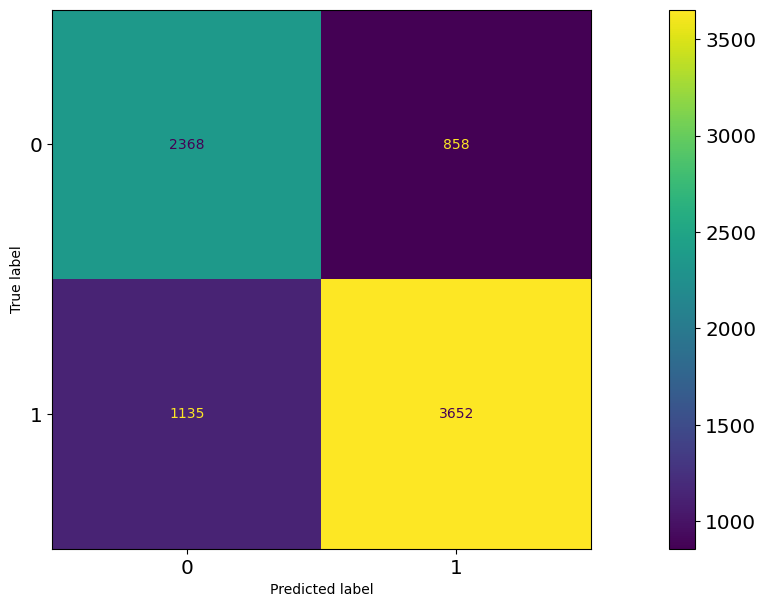

In [85]:
#confusion matrix train dengan HT
cm3_dt = confusion_matrix(y_train, rs2_dt.predict(X_train), labels=rs2_dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm3_dt, display_labels=rs2_dt.classes_)

disp.plot()

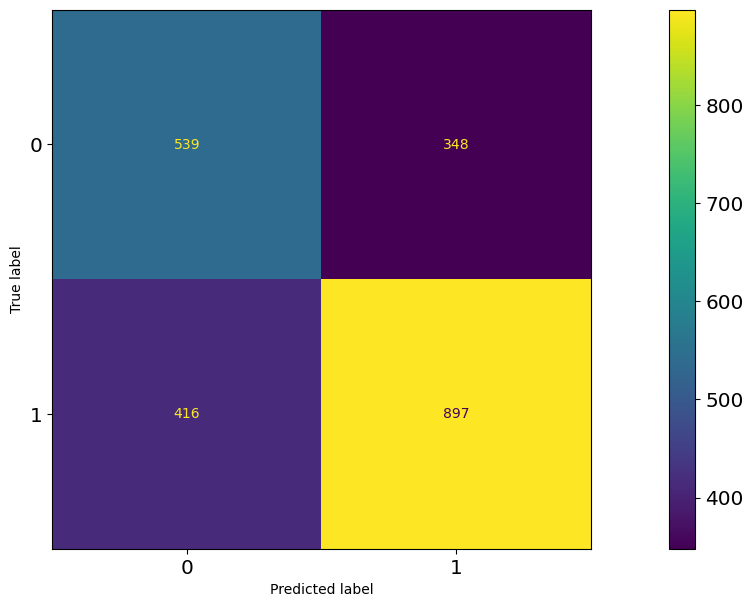

In [86]:
#confusion matrix test dengan HT
cm4_dt = confusion_matrix(y_test, rs2_dt.predict(X_test), labels=rs2_dt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm4_dt, display_labels=rs2_dt.classes_)

disp.plot()

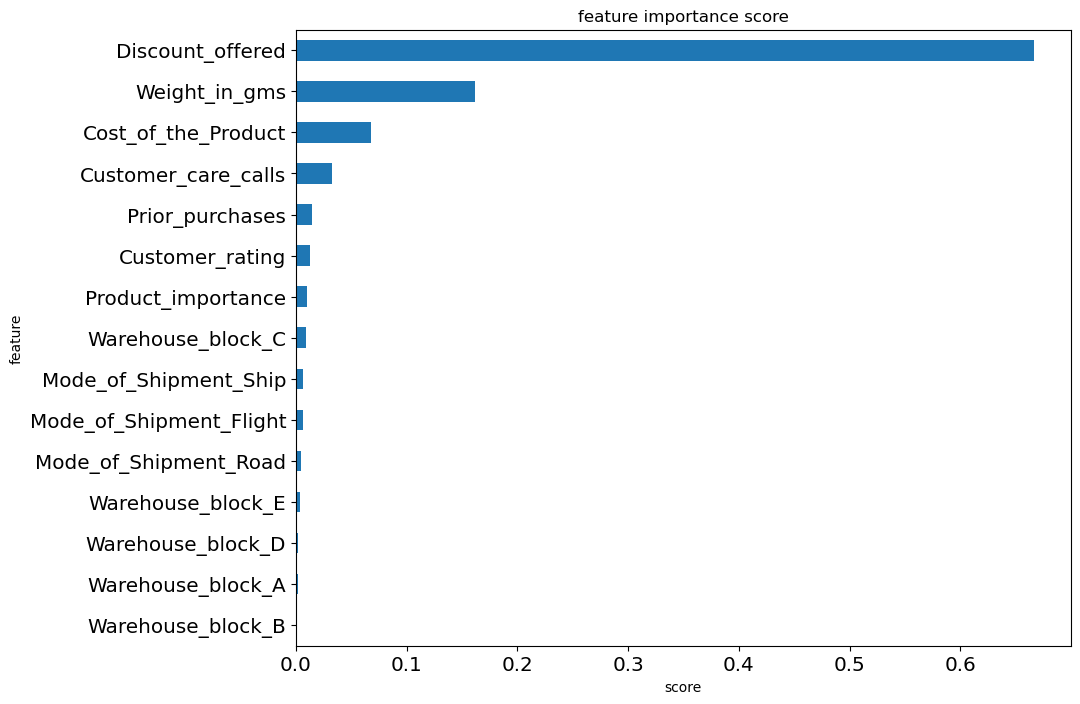

In [87]:
#feature importance dari fit model menggunakan HT
show_feature_importance(rs2_dt.best_estimator_)

## Random Forest

In [88]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
eval_classification(rf)

Accuracy (Test Set): 0.67
Accuracy (Train Set): 1.00
Recall (Test Set): 0.67
Recall (Train Set): 1.00
roc_auc (test-proba): 0.75
roc_auc (train-proba): 1.00
recall (crossval train): 1.0
recall (crossval test): 0.5794919008786432


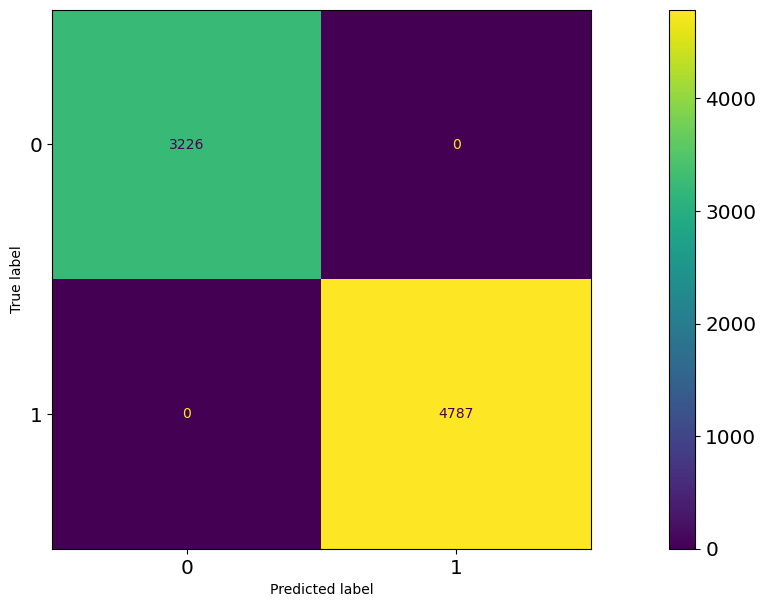

In [89]:
#Confusion Matrix train vs prediction
cm1_rf = confusion_matrix(y_train, rf.predict(X_train), labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1_rf,
                              display_labels=rf.classes_)
disp.plot()
plt.show()

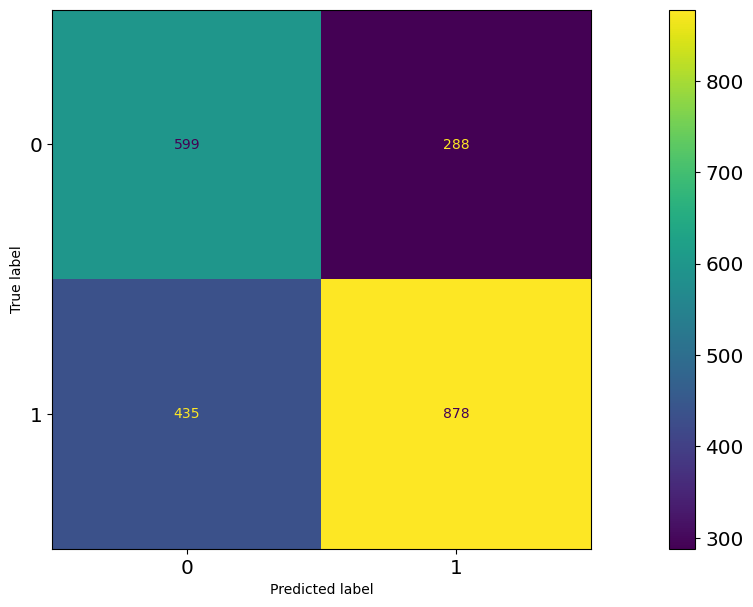

In [90]:
#Confusion Matrix test vs prediction
cm2_rf = confusion_matrix(y_test, rf.predict(X_test), labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2_rf,
                              display_labels=rf.classes_)
disp.plot()
plt.show()

In [91]:
#Percobaan 1 Hyperparameter Tuning
n_estimator = [int(x) for x in np.linspace(1, 200, 50)]
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(2, 100, 50)]
min_samples_split = [int(x) for x in np.linspace(2, 20, 10)]
min_samples_leaf = [int(x) for x in np.linspace(2, 20, 10)]
hyperparameters = dict(n_estimators=n_estimator, criterion=criterion, max_depth=max_depth,
                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

model = RandomForestClassifier(random_state=42)
rs_rf = RandomizedSearchCV(model, hyperparameters, scoring = 'recall', random_state=42, cv=5)
rs_rf.fit(X_train, y_train)

eval_classification(rs_rf)

Accuracy (Test Set): 0.67
Accuracy (Train Set): 0.94
Recall (Test Set): 0.63
Recall (Train Set): 0.92
roc_auc (test-proba): 0.75
roc_auc (train-proba): 0.99
recall (crossval train): 0.8069153267858278
recall (crossval test): 0.5226466572548436


In [92]:
show_best_hyperparameter(rs_rf)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 46, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 12, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 74, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


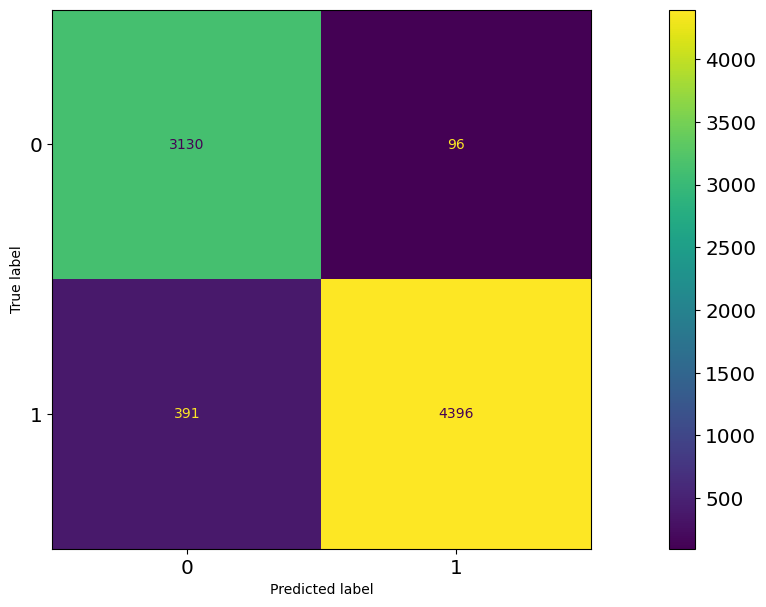

In [93]:
#Confusion Matrix train vs prediction
cm3_rf = confusion_matrix(y_train, rs_rf.predict(X_train), labels=rs_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm3_rf,
                              display_labels=rs_rf.classes_)
disp.plot()
plt.show()

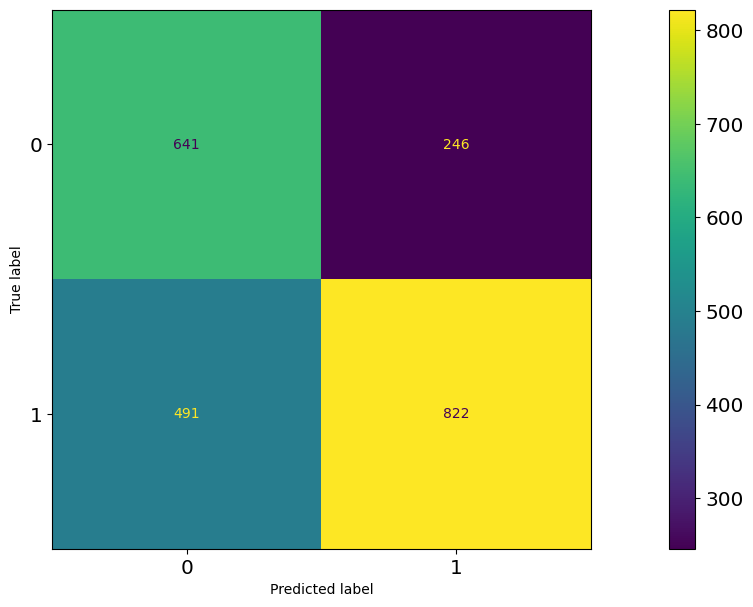

In [94]:
#Confusion Matrix test vs prediction
cm4_rf = confusion_matrix(y_test, rs_rf.predict(X_test), labels=rs_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix= cm4_rf,
                              display_labels= rs_rf.classes_)
disp.plot()
plt.show()

param value: 1; train: 0.8880300814706497; test: 0.7281035795887281
param value: 5; train: 0.9680384374347191; test: 0.7128712871287128
param value: 9; train: 0.9862126592855651; test: 0.7075399847677075
param value: 13; train: 0.9933152287445164; test: 0.6991622239146992
param value: 17; train: 0.997075412575726; test: 0.69002284843869
param value: 21; train: 0.9987466053895968; test: 0.7014470677837015
param value: 25; train: 0.9989555044913306; test: 0.6961157654226962
param value: 29; train: 0.9989555044913306; test: 0.6892612338156893
param value: 33; train: 0.9993733026947984; test: 0.6877380045696877
param value: 37; train: 0.9997911008982662; test: 0.6945925361766946
param value: 41; train: 0.9997911008982662; test: 0.6961157654226962
param value: 45; train: 0.9997911008982662; test: 0.6968773800456969
param value: 49; train: 1.0; test: 0.7014470677837015
param value: 53; train: 1.0; test: 0.6915460776846916
param value: 57; train: 1.0; test: 0.6854531607006854
param value: 61;

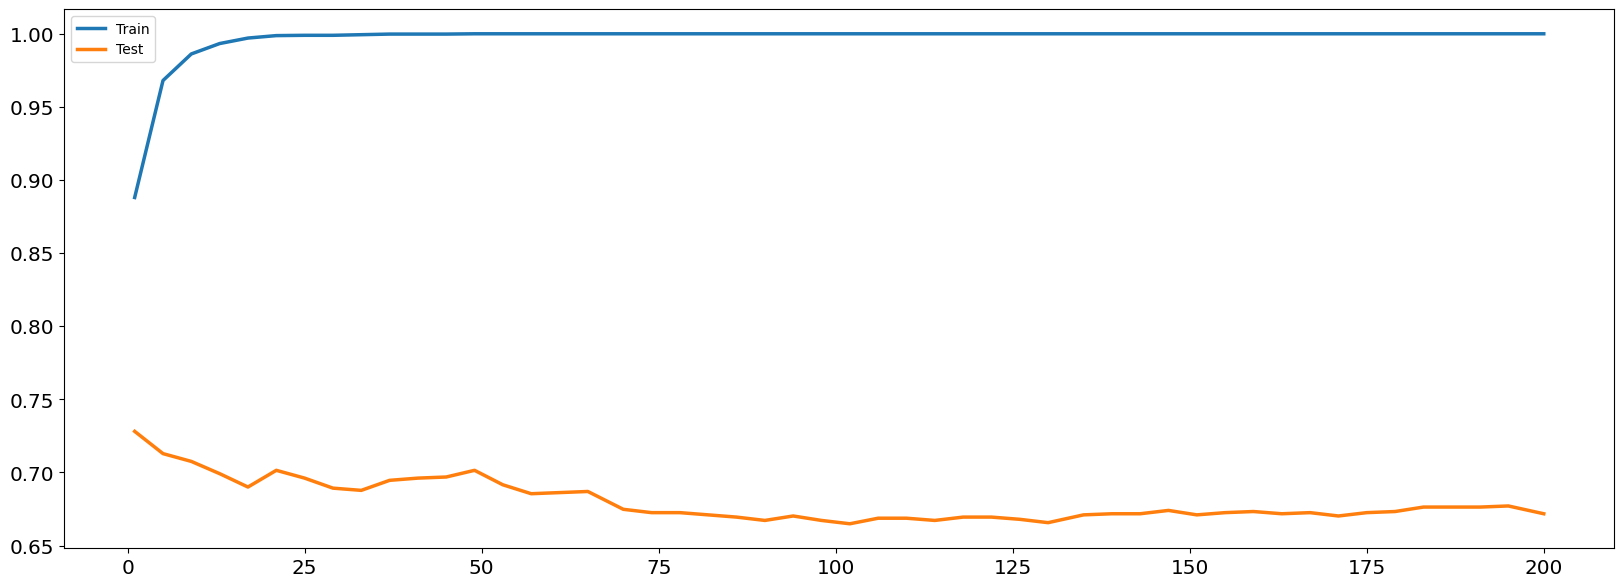

In [95]:
#Learning Curve

# n_estimator
param_values = [int(x) for x in np.linspace(1, 200, 50)]

train_scores = []
test_scores = []

for c in param_values:
    model = RandomForestClassifier(random_state=42, n_estimators=c)
    model.fit(X_train, y_train)

    # eval train
    y_pred_train = model.predict(X_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_scores.append(train_recall)

    # eval test
    y_pred_test = model.predict(X_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_scores.append(test_recall)

    print('param value: ' + str(c) + '; train: ' + str(train_recall) + '; test: ' + str(test_recall))

plt.plot(param_values, train_scores, label='Train')
plt.plot(param_values, test_scores, label='Test')
plt.legend()

param value: 2; train: 0.8119908084395238; test: 0.805026656511805
param value: 4; train: 0.6118654689784834; test: 0.6290936785986291
param value: 6; train: 0.5736369333611866; test: 0.5856816450875857
param value: 8; train: 0.6461249216628369; test: 0.5963442498095963
param value: 10; train: 0.7319824524754543; test: 0.6481340441736482
param value: 12; train: 0.8238980572383539; test: 0.6534653465346535
param value: 14; train: 0.8974305410486735; test: 0.6892612338156893
param value: 16; train: 0.945268435345728; test: 0.6999238385376999
param value: 18; train: 0.9676206392312513; test: 0.6999238385376999
param value: 20; train: 0.9780655943179445; test: 0.6945925361766946
param value: 22; train: 0.983288071861291; test: 0.693069306930693
param value: 24; train: 0.9822435763526217; test: 0.6976389946686976
param value: 26; train: 0.9853770628786296; test: 0.7083015993907082
param value: 28; train: 0.9857948610820974; test: 0.7006854531607006
param value: 30; train: 0.9866304574890328

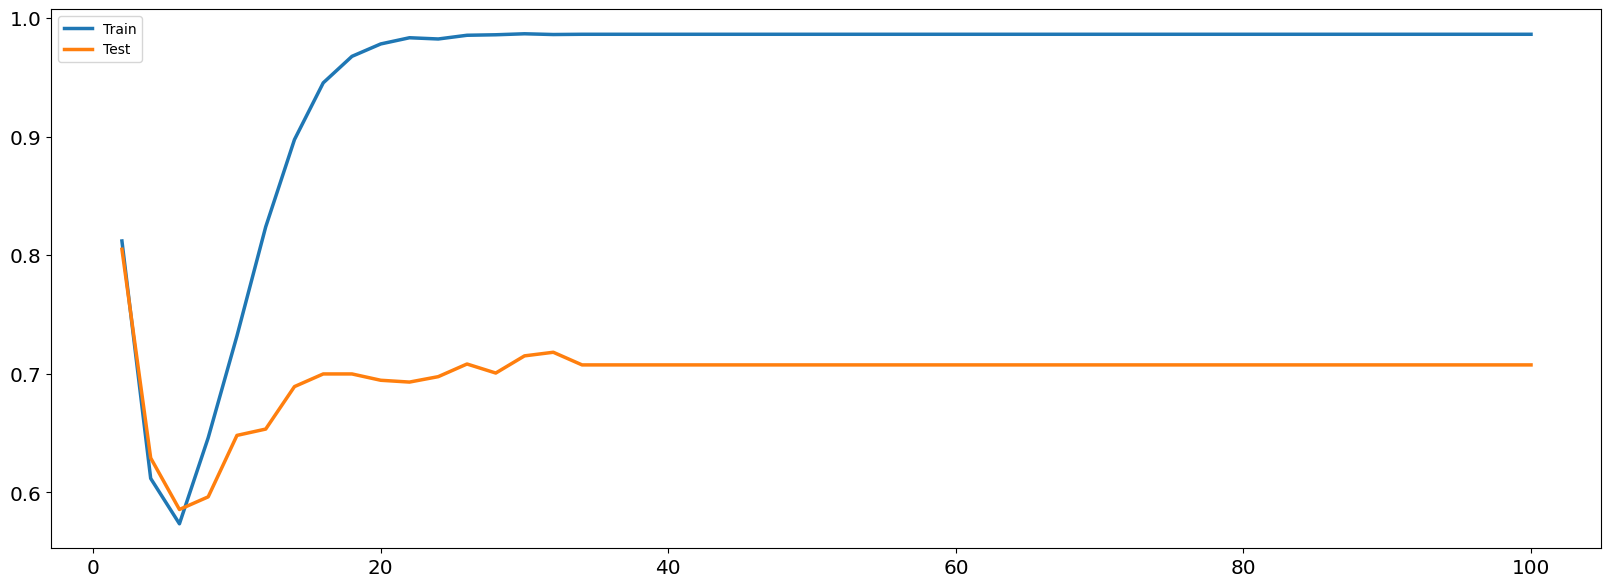

In [96]:
# max_depth
param_values = [int(x) for x in np.linspace(2, 100, 50)]

train_scores = []
test_scores = []

for c in param_values:
    model = RandomForestClassifier(random_state=42, n_estimators=9, max_depth=c)
    model.fit(X_train, y_train)

    # eval train
    y_pred_train = model.predict(X_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_scores.append(train_recall)

    # eval test
    y_pred_test = model.predict(X_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_scores.append(test_recall)

    print('param value: ' + str(c) + '; train: ' + str(train_recall) + '; test: ' + str(test_recall))

plt.plot(param_values, train_scores, label='Train')
plt.plot(param_values, test_scores, label='Test')
plt.legend()

param value: 2; train: 0.8119908084395238; test: 0.805026656511805
param value: 2; train: 0.8119908084395238; test: 0.805026656511805
param value: 3; train: 0.8119908084395238; test: 0.805026656511805
param value: 4; train: 0.8119908084395238; test: 0.805026656511805
param value: 5; train: 0.8119908084395238; test: 0.805026656511805
param value: 6; train: 0.8119908084395238; test: 0.805026656511805
param value: 7; train: 0.8119908084395238; test: 0.805026656511805
param value: 8; train: 0.8119908084395238; test: 0.805026656511805
param value: 9; train: 0.8119908084395238; test: 0.805026656511805
param value: 10; train: 0.8119908084395238; test: 0.805026656511805
param value: 11; train: 0.8119908084395238; test: 0.805026656511805
param value: 12; train: 0.8119908084395238; test: 0.805026656511805
param value: 13; train: 0.8119908084395238; test: 0.805026656511805
param value: 14; train: 0.8119908084395238; test: 0.805026656511805
param value: 15; train: 0.8119908084395238; test: 0.80502

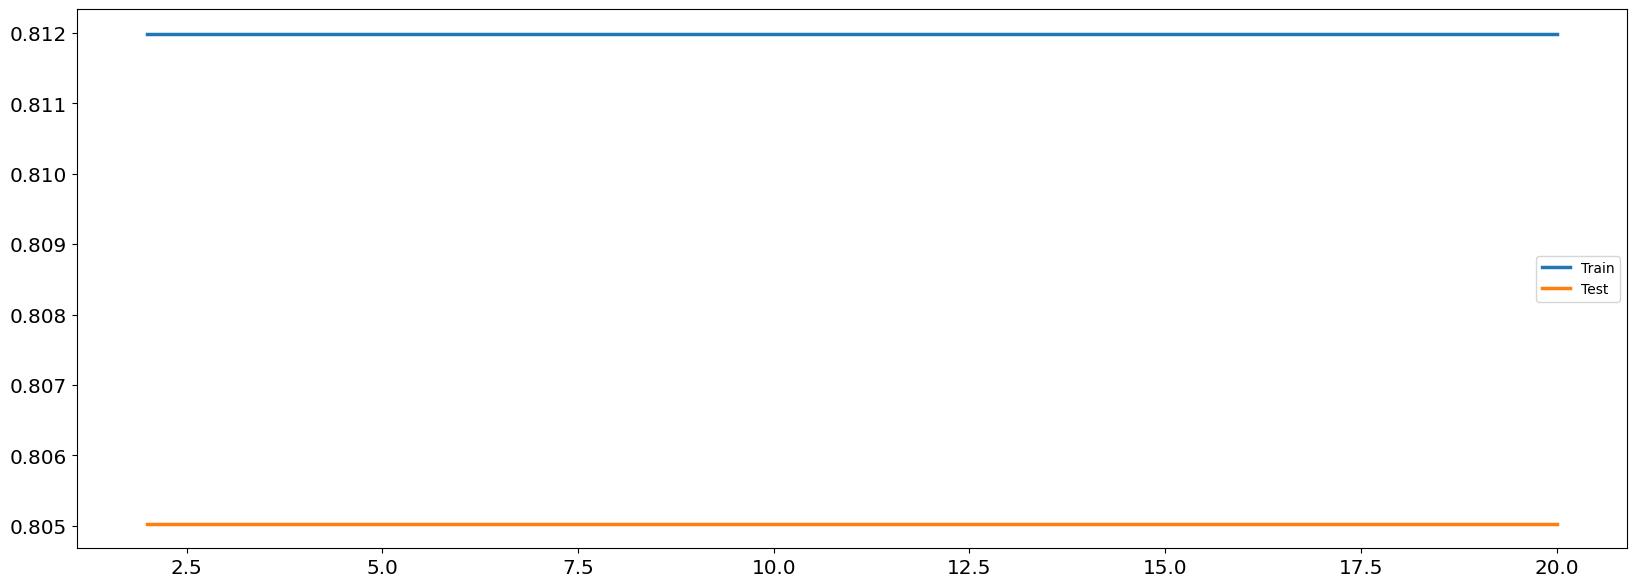

In [97]:
# min_sample_split
param_values = [int(x) for x in np.linspace(2, 20, 20)]

train_scores = []
test_scores = []

for c in param_values:
    model = RandomForestClassifier(random_state=42, n_estimators=9, max_depth=2, min_samples_split=c)
    model.fit(X_train, y_train)

    # eval train
    y_pred_train = model.predict(X_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_scores.append(train_recall)

    # eval test
    y_pred_test = model.predict(X_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_scores.append(test_recall)

    print('param value: ' + str(c) + '; train: ' + str(train_recall) + '; test: ' + str(test_recall))

plt.plot(param_values, train_scores, label='Train')
plt.plot(param_values, test_scores, label='Test')
plt.legend()

param value: 2; train: 0.8119908084395238; test: 0.805026656511805
param value: 2; train: 0.8119908084395238; test: 0.805026656511805
param value: 3; train: 0.8119908084395238; test: 0.805026656511805
param value: 4; train: 0.8119908084395238; test: 0.805026656511805
param value: 5; train: 0.8119908084395238; test: 0.805026656511805
param value: 6; train: 0.8119908084395238; test: 0.805026656511805
param value: 7; train: 0.8119908084395238; test: 0.805026656511805
param value: 8; train: 0.8119908084395238; test: 0.805026656511805
param value: 9; train: 0.8119908084395238; test: 0.805026656511805
param value: 10; train: 0.8119908084395238; test: 0.805026656511805
param value: 11; train: 0.8119908084395238; test: 0.805026656511805
param value: 12; train: 0.8119908084395238; test: 0.805026656511805
param value: 13; train: 0.8119908084395238; test: 0.805026656511805
param value: 14; train: 0.8119908084395238; test: 0.805026656511805
param value: 15; train: 0.8119908084395238; test: 0.80502

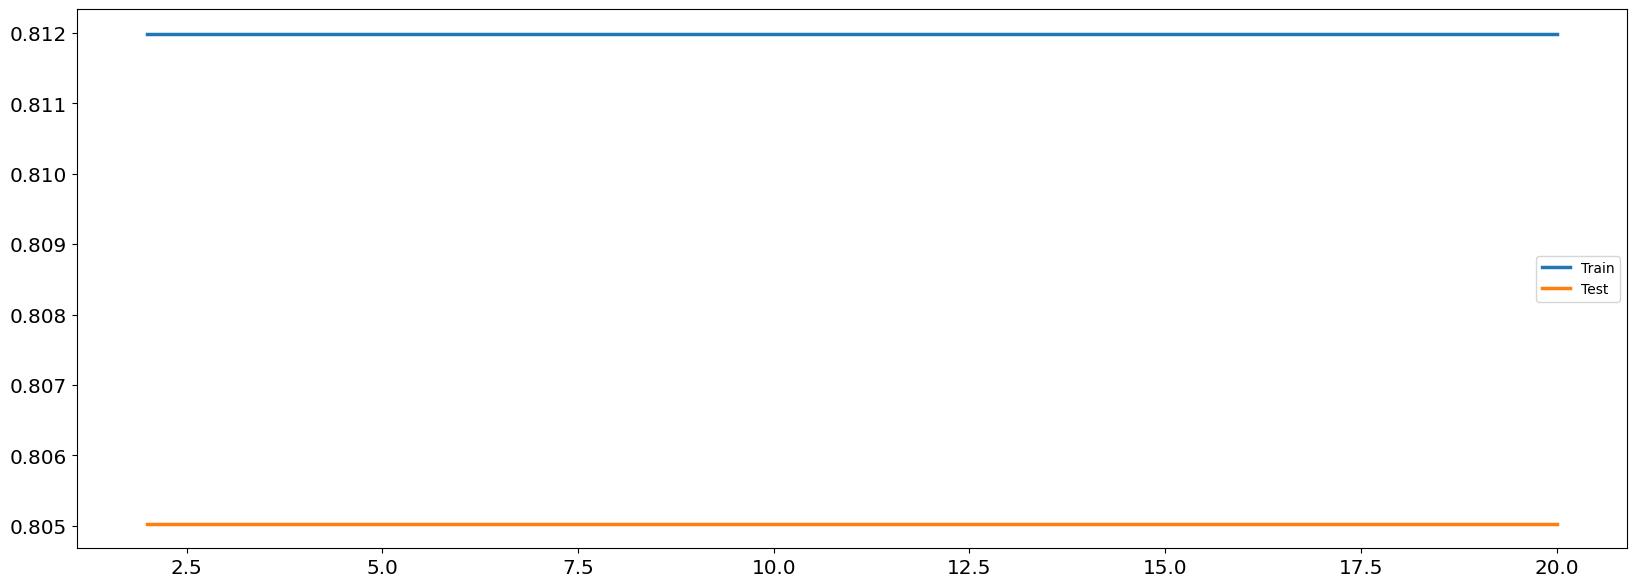

In [98]:
# min_sample_leaf
param_values = [int(x) for x in np.linspace(2, 20, 20)]

train_scores = []
test_scores = []

for c in param_values:
    model = RandomForestClassifier(random_state=42, n_estimators=9, max_depth=2, min_samples_split=4, min_samples_leaf=c)
    model.fit(X_train, y_train)

    # eval train
    y_pred_train = model.predict(X_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_scores.append(train_recall)

    # eval test
    y_pred_test = model.predict(X_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_scores.append(test_recall)

    print('param value: ' + str(c) + '; train: ' + str(train_recall) + '; test: ' + str(test_recall))

plt.plot(param_values, train_scores, label='Train')
plt.plot(param_values, test_scores, label='Test')
plt.legend()

In [99]:
#last experiment n_estimators=9, max_depth=2, min_samples_split=4, min_samples_leaf=13
rf_2 = RandomForestClassifier(random_state=42, n_estimators=9, max_depth=2, min_samples_split=4, min_samples_leaf=13)

rf_2.fit(X_train, y_train)
eval_classification(rf_2)

Accuracy (Test Set): 0.65
Accuracy (Train Set): 0.65
Recall (Test Set): 0.81
Recall (Train Set): 0.81
roc_auc (test-proba): 0.75
roc_auc (train-proba): 0.75
recall (crossval train): 0.8082143228954122
recall (crossval test): 0.6148707577136701


In [100]:
class_report_train(rf_2)

              precision    recall  f1-score   support

           0       0.59      0.41      0.48      3226
           1       0.67      0.81      0.73      4787

    accuracy                           0.65      8013
   macro avg       0.63      0.61      0.61      8013
weighted avg       0.64      0.65      0.63      8013



In [101]:
class_report_test(rf_2)

              precision    recall  f1-score   support

           0       0.59      0.41      0.49       887
           1       0.67      0.81      0.73      1313

    accuracy                           0.65      2200
   macro avg       0.63      0.61      0.61      2200
weighted avg       0.64      0.65      0.63      2200



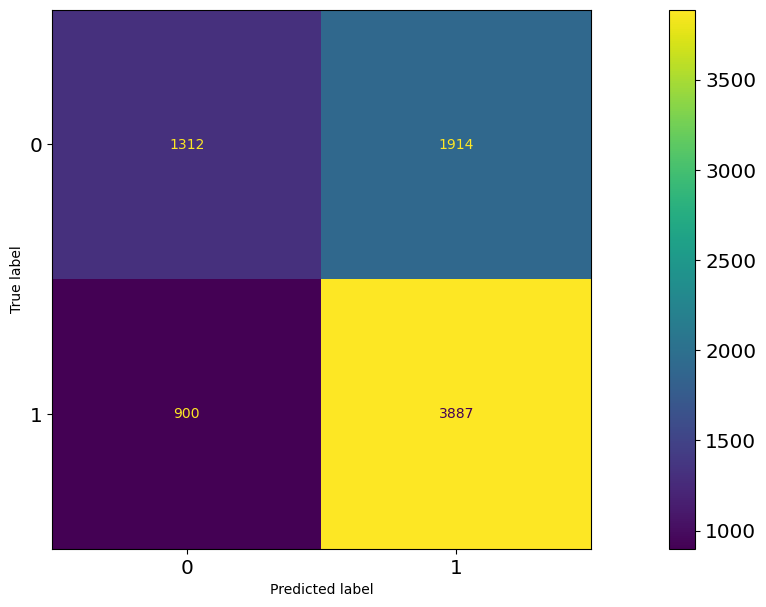

In [102]:
cm5_rf = confusion_matrix(y_train, rf_2.predict(X_train), labels=rf_2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm5_rf, display_labels=rf_2.classes_)

disp.plot()

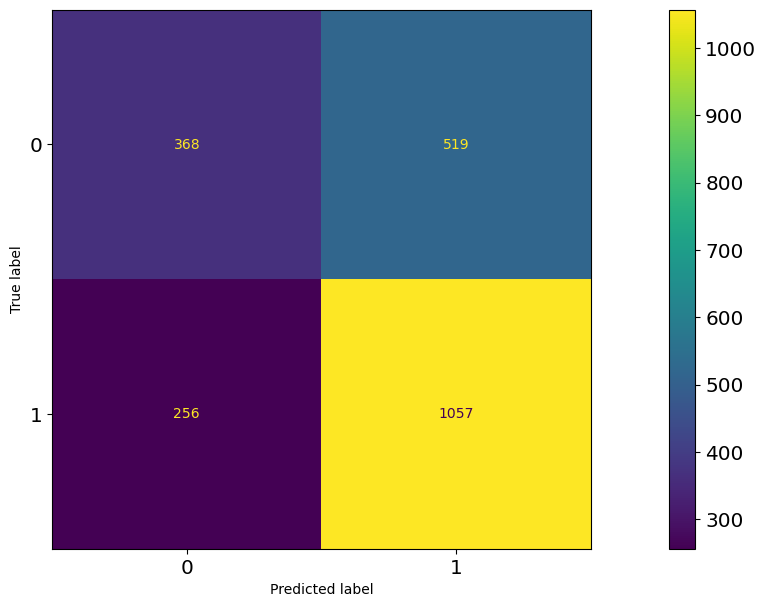

In [103]:
cm6_rf = confusion_matrix(y_test, rf_2.predict(X_test), labels=rf_2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm6_rf, display_labels=rf_2.classes_)

disp.plot()

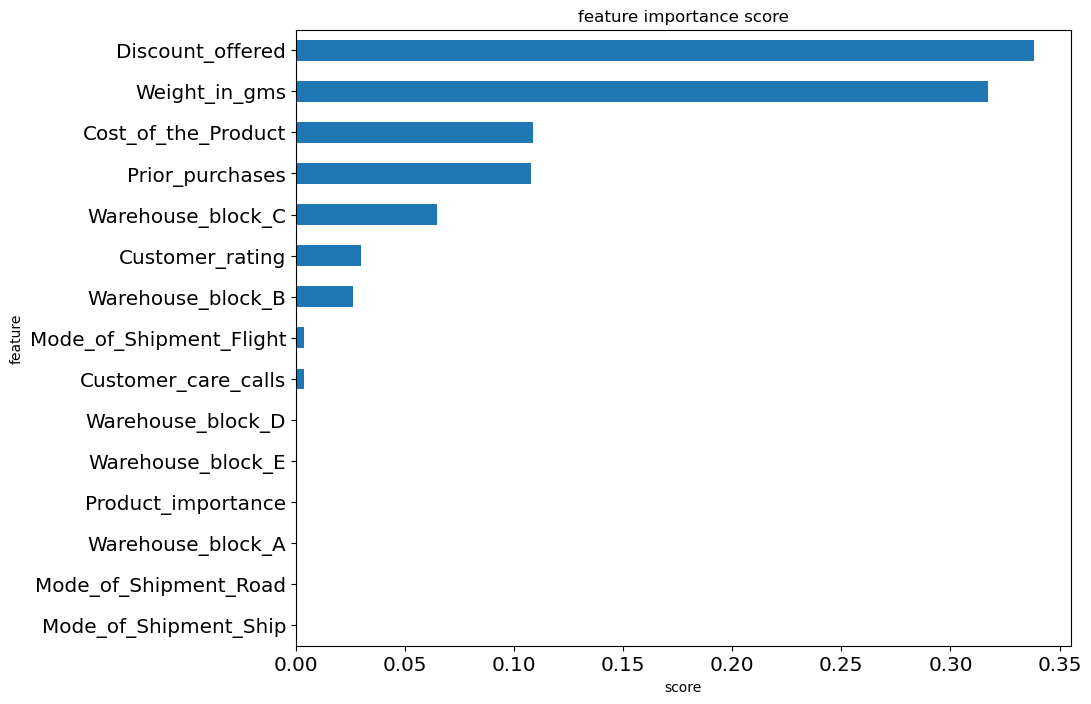

In [104]:
show_feature_importance(rf_2)